# Overview of this notebook
This notebooks is a continuation of 'Cleaning_next_part.ipynb' notebook.
Here we primary build predicition models for the different orbit parameters based on Gaussian Process Regression.
Next follows the 'Regression_GPRmodreg.ipynb', were we perform forecasts of the parameters of interest to us, like angles, eccentricity and daily revolutions.

In [1]:
# additional to previous imports, several elements from sklearn are imported
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns 
import bokeh.plotting as bkh
from bokeh.io import output_notebook
from datetime import datetime
from datetime import timedelta
from sgp4.earth_gravity import wgs72 #wgs84, wgs72old
from sgp4.io import twoline2rv
import sklearn.preprocessing as ppimport
from bokeh.models import ColumnDataSource, DataRange1d, Plot, LinearAxis, Grid, Range1d, LabelSet, Label, LogAxis, GMapOptions
from bokeh.io import export_svgs, output_file, show, export_png
from bokeh.transform import dodge
import bokeh.colors as colors
from bokeh.colors import Color
from bokeh.models.ranges import FactorRange
from mpl_toolkits.mplot3d import Axes3D 
import plotly.graph_objects as go
from sgp4.earth_gravity import wgs72 #wgs84, wgs72old
from sgp4.io import twoline2rv
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import leastsq, curve_fit
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.metrics import mean_squared_error
import math
import warnings

In [2]:
warnings.simplefilter(action='ignore')

In [3]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

### Load dataframes with multi-index and without

In [4]:
dfdeb = pickle.load(open('dfdeb_fc.p', 'rb'))
dfdeb_m = pickle.load(open('dfdeb_m_fc.p', 'rb'))

In [5]:
dfdeb.head()

,m,argp,bstar,ddn_o6,dn_o2,ecc,epoch_day,epoch_year,inc,int_desig,n,norad,raan,rev_num,line1,line2,object_id,object_name,country,period,inclination,apogee,perigee,rcs_size,launch,debc,apo,peri,date,datetimes,x,y,z
11477,277.0305,84.1924,0.000106,0.0,0.000002,0.009775,343.944544,2018,66.7295,61015D,14.231585,119,299.5038,96720,1 00119U 61015D 18343.94454394 +.00000169 +0...,2 00119 066.7295 299.5038 0097752 084.1924 277...,1961-015D,THOR ABLESTAR DEB,US,101.18,66.73,891.0,738.0,MEDIUM,1961-06-29,True,7263.139166,7122.516505,2018.939739,2018-12-10 21:40:08.596416,-4060.488530,3048.157812,-5186.244037
11478,277.7405,83.4810,0.000129,0.0,0.000002,0.009778,344.858134,2018,66.7296,61015D,14.231592,119,297.1432,96733,1 00119U 61015D 18344.85813364 +.00000223 +0...,2 00119 066.7296 297.1432 0097776 083.4810 277...,1961-015D,THOR ABLESTAR DEB,US,101.18,66.73,891.0,738.0,MEDIUM,1961-06-29,True,7263.154061,7122.496920,2018.942235,2018-12-11 19:35:42.746496,-3931.979807,3214.986230,-5185.190010
11479,278.0692,83.1515,0.000138,0.0,0.000002,0.009778,345.279790,2018,66.7296,61015D,14.231594,119,296.0537,96739,1 00119U 61015D 18345.27979033 +.00000244 +0...,2 00119 066.7296 296.0537 0097780 083.1515 278...,1961-015D,THOR ABLESTAR DEB,US,101.18,66.73,891.0,738.0,MEDIUM,1961-06-29,True,7263.156012,7122.493135,2018.943387,2018-12-12 05:42:53.884512,-3870.389071,3290.622130,-5184.371927
11480,278.7813,82.4378,0.000155,0.0,0.000003,0.009780,346.193380,2018,66.7297,61015D,14.231601,119,293.6931,96795,1 00119U 61015D 18346.19337954 +.00000286 +0...,2 00119 066.7297 293.6931 0097799 082.4378 278...,1961-015D,THOR ABLESTAR DEB,US,101.18,66.73,891.0,738.0,MEDIUM,1961-06-29,True,7263.167586,7122.477417,2018.945884,2018-12-13 03:38:27.992256,-3731.905261,3449.253057,-5183.435970
11481,279.3214,81.8966,0.000168,0.0,0.000003,0.009784,346.896140,2018,66.7297,61015D,14.231606,119,291.8774,96762,1 00119U 61015D 18346.89614006 +.00000316 +0...,2 00119 066.7297 291.8774 0097835 081.8966 279...,1961-015D,THOR ABLESTAR DEB,US,101.18,66.73,891.0,738.0,MEDIUM,1961-06-29,True,7263.191561,7122.449641,2018.947804,2018-12-13 20:30:26.501184,-3620.867640,3563.808386,-5185.222646


## Previously developed calculations for further calcs here

In [6]:
def xyz_model(line1, line2, date):
    satellite = twoline2rv(line1, line2, wgs72)
 #   pass
    #position, velocity = satellite.propagate(
    #2000, 6, 29, 12, 50, 19) # year month day hour min sec
    position, velocity = satellite.propagate(
    date.year, date.month, date.day, date.hour, date.minute, date.second) # year month day hour min sec
    return position

In [7]:
def coordcalt(line1, line2, date):
    xcon = list()
    ycon = list()
    zcon = list()
    for i in range(len(line1)):
        xyz = xyz_model(line1[i], line2[i], date)
        xcon.append(xyz[0])
        ycon.append(xyz[1])
        zcon.append(xyz[2])
    return xcon, ycon, zcon

In [8]:
def calorbitxyz(inc, n, raan, ecc, argp, npoints = 100):
    #raan = np.pi / 180
    #inc = np.pi / 180
    x = list()
    y = list()
    z = list()
    mu = 3.986004418E5 * (3600 * 24) ** 2
    earthreq = 6378
    apo = np.power(mu / (4. * (np.pi * n) ** 2), 1. / 3.)
    peri = apo * (1 - ecc)
    a = (apo + peri) / 2
    oecc = np.sqrt(1 - ecc ** 2)
    b = a * oecc
    b2 = b * b
    a2 = a * a
    xp = np.linspace(-a, a, npoints) 
    argp_cos = np.cos(argp - 90)
    argp_sin = np.sin(argp - 90) #periapsis regarding to x-axis
    raan_cos = np.cos(raan)
    raan_sin = np.sin(raan)
    inc_cos = np.cos(inc)
    inc_sin = np.sin(inc)
    #print(xp)
    for i in xp:
        x.append(i)
        x.append(i)
        yabs = np.sqrt(b2 - i * i * b2 / a2)
        y.append(yabs)
        y.append(-yabs)
    x = np.array(x)
    y = np.array(y)
    xn = x * argp_cos - y * argp_sin
    yn = y * argp_cos + x * argp_sin
    x = xn
    y = yn
    xn = x * raan_cos - y * raan_sin
    yn = y * raan_cos + x * raan_sin
    z = xn * np.sin(inc)
    xn *= np.cos(inc)
    x = xn * raan_cos + yn * raan_sin
    y = yn * raan_cos - xn * raan_sin
    xn
    yn
    zn
    # rotation of x, y, z according to argp
    return x, y, z

In [9]:
mu = 3.986004418E5 * (3600 * 24) ** 2
earthreq = 6378
def apogeecal(n, ecc):
    return np.power(mu / (4. * (np.pi * n) ** 2), 1. / 3.) * (1 + ecc)
def perigeecal(n, ecc):
    return np.power(mu / (4. * (np.pi * n) ** 2), 1. / 3.) * (1 - ecc)

In [10]:
norads = dfdeb.norad.unique()

In [11]:
len(dfdeb_m.loc[norads[0]].line1)

495

### Kernel for regression base example

In [638]:
kernel = ExpSineSquared(length_scale = 1000, periodicity = 1, length_scale_bounds = (1E-3, 1E5),
                        periodicity_bounds = (1E-4, 1E3)) * DotProduct(sigma_0=1., sigma_0_bounds=(1e-05, 1e5))# \
        #* C(1.0, (1e-3, 1e1)) * RBF(10, (1e-1, 1e2))
#C(1.0, (1e-1, 1e1)) * RBF(10, (1e-1, 1e1)) #prior kernel = 'linear'
krreg = KernelRidge(alpha=0.00000001, kernel=kernel, gamma='linear', degree=5, coef0=1, kernel_params=None)

krreg = GaussianProcessRegressor(kernel=kernel, alpha=0.000000000001)
#krreg = Ridge(alpha=0.001, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)
#krreg = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
#krreg = KernelRidge(alpha=0.01, kernel='linear', gamma='linear', degree=5, coef0=1, kernel_params=None)
#DecisionTreeRegressor(criterion = 'mae', max_depth = 4, min_samples_split = 2, min_samples_leaf = 1)

### Reduced dataframe for regressions

In [12]:

dfdebreg = dfdeb_m.drop(['line1', 'line2', 'object_id', 'object_name', 'rcs_size', 'debc',
                        'apo', 'peri', 'country', 'rev_num', 'int_desig', 'ddn_o6', 
                         'epoch_day', 'epoch_year', 'period', 'apogee', 'perigee', 'inclination',
                        'launch'],axis = 1)
dfdebreg.head()

m     argp     bstar     dn_o2       ecc      inc  \
norad date                                                                    
119   2018.916314  270.3322  90.8959  0.000116  0.000002  0.009762  66.7291   
      2018.918618  270.9942  90.2340  0.000132  0.000002  0.009762  66.7292   
      2018.920538  271.5473  89.6810  0.000139  0.000002  0.009764  66.7292   
      2018.921690  271.8807  89.3476  0.000145  0.000003  0.009765  66.7292   
      2018.924762  272.7554  88.4725  0.000146  0.000003  0.009766  66.7293   

                           n      raan                   datetimes  \
norad date                                                           
119   2018.916314  14.231530  321.6569  2018-12-02 07:54:00.447264   
      2018.918618  14.231535  319.4778  2018-12-03 04:08:23.052480   
      2018.920538  14.231539  317.6620  2018-12-03 21:00:21.864672   
      2018.921690  14.231542  316.5724  2018-12-04 07:07:33.134016   
      2018.924762  14.231550  313.6672  2018-12-05 10:06:43.134336   

                             x            y            z  
norad date                                                
119   2018.916314 -4901.525329  1282.372903 -5189.980904  
      2018.918618 -4848.810102  1466.583764 -5191.453009  
      2018.920538 -4802.750196  1624.538882 -5187.783987  
      2018.921690 -4769.396965  1712.059910 -5190.812972  
      2018.924762 -4677.366596  1952.818559 -5190.482112

In [13]:
oi_num = 1#14#1189#1189#39#-600#2764#2680#2576#2355#1487#1#235#135#37#17#19

#### Times for testing regression (datfit) and timeconstraint for fitting hyperparameters

In [14]:
datfit = datetime(year = 2019, month = 10, day = 1, hour = 0, minute = 0, second = 0)
dattail = datetime(year = 2019, month = 2, day = 1, hour = 0, minute = 0, second = 0)

#### Simple Example of Gaussian regression

0.002302896959008649 0.002302896959008649 0.0
556 556
0.9817895691019539


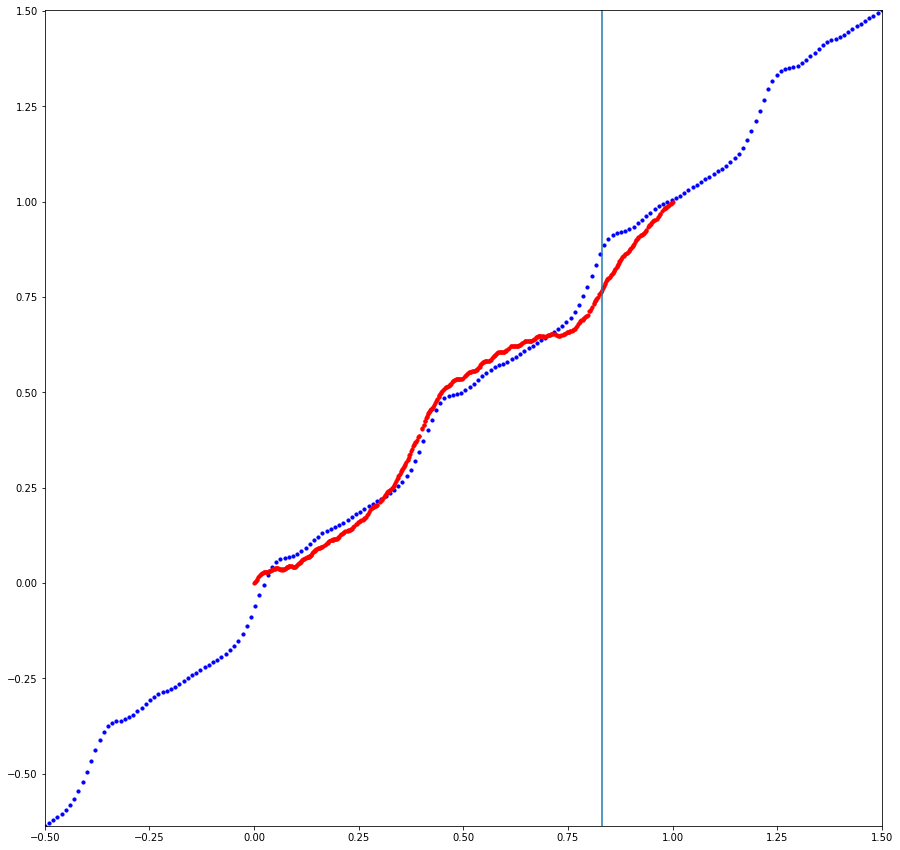

In [43]:
kernel = ExpSineSquared(length_scale = 1, periodicity = 0.4, length_scale_bounds = (1E-4, 5E1),
                        periodicity_bounds = (1E-3, 1E0)) * C(0.1, (1e-3, 1e0)) \
        + DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))#*RBF(0.001, (1e-5, 1e2))#*C(1.0, (1e-3, 1e2))# \
#kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e3))
#kernel = 'linear'
kernel_params = None#('periodicity')
#gprn = KernelRidge(alpha=1e-2, kernel=kernel, gamma='linear', degree=10, coef0=1, kernel_params=kernel_params)
##kernel = DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))
#kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))
#kernel = 'linear'
gprn = KernelRidge(kernel=kernel, alpha=1e-4, kernel_params=kernel_params)
# first extract linear behavior, then extract oscillatory pattern, forecast

X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
Xsub = dfdebreg[dfdebreg.datetimes < datfit].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

#X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

y = dfdebreg.loc[norads[oi_num]].n.values
ysub = dfdebreg[dfdebreg.datetimes < datfit].loc[norads[oi_num]].n.values

minmaxn = MinMaxScaler()
minmaxt = MinMaxScaler()
minmaxt.fit(X.reshape(-1, 1))
#minmaxn.fit(np.array([1,24]).reshape(-1, 1))
minmaxn.fit(y.reshape(-1, 1))
y = minmaxn.transform(y.reshape(-1, 1))
X = minmaxt.transform(X.reshape(-1, 1))
ysub = minmaxn.transform(ysub.reshape(-1, 1))
Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
# first use linear to not overfit

#krreg = GaussianProcessRegressor(kernel=kernel, alpha=max(1e-10,0.1 * abs(y[1][0]- y[0][0])), n_restarts_optimizer = 10, random_state=42)

print(y[1][0]- y[0][0], y[1][0], y[0][0])

X_train, X_test, y_train, y_test = train_test_split(X, dfdebreg.loc[norads[oi_num]].n.values,
                                                    test_size=0.33, random_state=10)
#degree = 1
#poly_features = PolynomialFeatures(degree=degree)
#X_trainp = poly_features.fit_transform(X_train)
#X_testp = poly_features.fit_transform(X_test)
X_train = X
X_test = X
y_train = y
y_test = y
X_trainp = X_train
X_testp = X_test
X_testb = np.linspace(-0.5,1.5,200).reshape(-1,1)
print(len(X_trainp), len(y_train))
#krreg.fit(X_trainp, y_train)
gprn.fit(Xsub, ysub)

y_pred = gprn.predict(X_testb)
print(gprn.score(X, y))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X_testb, y_pred, c = 'blue', s = 10)
plt.scatter(X_test, y_test, c = 'red', s = 10)
#print(krreg.params)
#krreg.

## Functions that give the regression function plus normalizer for data plus simple hyperparameter variation

### fit function for n (number of daily revolutions)

In [19]:


def fnreg(oi_num, dattaili = dattail, datfiti = datfit, addXY = False):
    kernel = ExpSineSquared(length_scale = 1, periodicity = 0.1, length_scale_bounds = (1E-3, 5E0),
                            periodicity_bounds = (1E-3, 1E1)) *  C(0.1, (1e-3, 2e0)) \
            + DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))

    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))


    X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

    y = dfdebreg.loc[norads[oi_num]].n.values
    ysub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].n.values
    ysub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].n.values
    ysub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].n.values


    minmaxn = MinMaxScaler()
    minmaxt = MinMaxScaler()
    minmaxt.fit(X.reshape(-1, 1))
    #minmaxn.fit(np.array([1,24]).reshape(-1, 1))
    minmaxn.fit(y.reshape(-1, 1))
    y = minmaxn.transform(y.reshape(-1, 1))
    X = minmaxt.transform(X.reshape(-1, 1))
    ysub = minmaxn.transform(ysub.reshape(-1, 1))
    Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
    ysub2 = minmaxn.transform(ysub2.reshape(-1, 1))
    Xsub2 = minmaxt.transform(Xsub2.reshape(-1, 1))
    ysub3 = minmaxn.transform(ysub3.reshape(-1, 1))
    Xsub3 = minmaxt.transform(Xsub3.reshape(-1, 1))

    alphaval = [1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5,1e-6,3e-6,1e-7,3e-7,1e-8,3e-8,1e-9,3e-9,1e-10]
    errlist = list()
    for a in alphaval:

        gprn = KernelRidge(kernel=kernel, alpha=a)
        # first extract linear behavior, then extract oscillatory pattern, forecast
        gprn.fit(Xsub2, ysub2)
        #y_pred = gprn.predict(Xsub3)
        #errlist.append(mean_squared_error(ysub3, y_pred))
        errlist.append(gprn.score(Xsub3, ysub3))
        #gprn.fit(Xsub, ysub)
        #print(gprn.score(X, y))

    alpha = alphaval[np.argmax(errlist)]
    #alpha = alphaval[np.argmin(errlist)]
    print(alpha)
    print(errlist)

    # perform gradient descent
    def gprna(alphah):
        gprb = KernelRidge(kernel=kernel, alpha=alphah, n_restarts_optimizer = 10, random_state=42)
        gprb.fit(Xsub2, ysub2)
        #y_pred = gprn.predict(Xsub3)
        #return mean_squared_error(ysub3, y_pred)
        return gprb.score(Xsub3, ysub3)

    boosting = False
    if boosting:
        alphan = alpha * 1.01
        g1 = (1 - gprna(alpha)) ** 2
        g2 = (1 - gprna(alphan)) ** 2
        g1 = gprna(alpha)
        g2 = gprna(alphan)
        igrad = (g1 - g2) / (alpha - alphan)
        if igrad != 0:
            basel = 0.05 * abs(alphan / (igrad))
            alphan = alpha
            alpha -= basel * igrad
            for i in range(5):
                g2 = g1
                g1 = (1 - gprna(alpha)) ** 2
                #g2 = (1 - gprna(alphan)) ** 2
                #g1 = gprna(alpha)
                #g2 = gprna(alphan)
                igrad = (g1 - g2) / (alpha - alphan)
                if igrad != 0:
                    alphan = alpha
                    alpha -= basel * igrad
                else: break


    #technically look for better alpha based on gradient boosting
    print(alpha)
    gprn = KernelRidge(kernel=kernel, alpha=alpha, n_restarts_optimizer = 10, random_state=42)
    gprn.fit(Xsub, ysub)
    if addXY: return gprn, minmaxn, minmaxt, X, y
    return gprn, minmaxn, minmaxt

#X_test = np.linspace(-0.5,1.5,200).reshape(-1,1)
#y_pred = gprn.predict(X_test)
#print(gprn.score(X, y))

#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
#plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
#plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
#plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
#plt.scatter(X, y, c = 'blue', s = 10)
#plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)
#krreg.

### print of fit for n

0.001
[-0.9891129522207773, -0.8445762290389294, 0.8185682243898125, -1.001100846037743, 0.7283376403391082, 0.5048861658818573, -10.649394227914204, -9.40321977301001, -4.171780610302976, -2.5352187228236756, -5.620662545725996, -4.028137637342764, -4.406103370298348, -6.217022003497814, -5.361302528289916, -0.2881787008533445, -0.2972553482961111]
0.001
0.9964647933149686


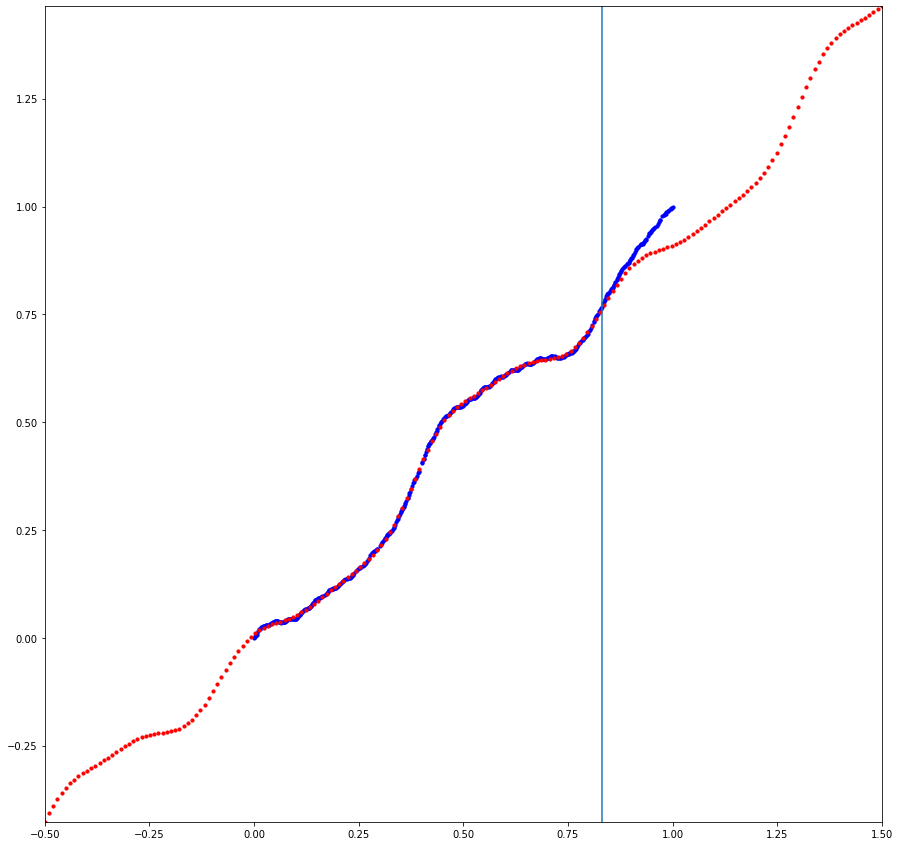

In [17]:
gprn, minmaxn, minmaxt, X, y = fnreg(oi_num, addXY = True)
X_test = np.linspace(-0.5,1.5,200).reshape(-1,1)
y_pred = gprn.predict(X_test)
print(gprn.score(X, y))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X, y, c = 'blue', s = 10)
plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)

### fit function for eccentricity 

In [18]:
#include tail fit # eccentricity

def fereg(oi_num, dattaili = dattail, datfiti = datfit, addXY = False):
    kernel = ExpSineSquared(length_scale = 1, periodicity = 0.1, length_scale_bounds = (1E-3, 5E0),
                            periodicity_bounds = (1E-3, 1E1)) *  C(0.1, (1e-3, 2e0)) \
            + DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))

    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))


    X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

    y = dfdebreg.loc[norads[oi_num]].ecc.values
    ysub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].ecc.values
    ysub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].ecc.values
    ysub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].ecc.values


    minmaxe = MinMaxScaler()
    minmaxt = MinMaxScaler()
    minmaxt.fit(X.reshape(-1, 1))
    #minmaxn.fit(np.array([1,24]).reshape(-1, 1))
    minmaxe.fit(y.reshape(-1, 1))
    y = minmaxe.transform(y.reshape(-1, 1))
    X = minmaxt.transform(X.reshape(-1, 1))
    ysub = minmaxe.transform(ysub.reshape(-1, 1))
    Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
    ysub2 = minmaxe.transform(ysub2.reshape(-1, 1))
    Xsub2 = minmaxt.transform(Xsub2.reshape(-1, 1))
    ysub3 = minmaxe.transform(ysub3.reshape(-1, 1))
    Xsub3 = minmaxt.transform(Xsub3.reshape(-1, 1))

    alphaval = [1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5,1e-6,3e-6,1e-7,3e-7,1e-8,3e-8,1e-9,3e-9,1e-10]
    errlist = list()
    for a in alphaval:

        gpre = GaussianProcessRegressor(kernel=kernel, alpha=a, n_restarts_optimizer = 10, random_state=42)
        # first extract linear behavior, then extract oscillatory pattern, forecast
        gpre.fit(Xsub2, ysub2)
        #y_pred = gprn.predict(Xsub3)
        #errlist.append(mean_squared_error(ysub3, y_pred))
        errlist.append(gpre.score(Xsub3, ysub3))
        #gprn.fit(Xsub, ysub)
        #print(gprn.score(X, y))

    alpha = alphaval[np.argmax(errlist)]
    #alpha = alphaval[np.argmin(errlist)]

    #technically look for better alpha based on gradient boosting
    print(alpha)
    print(errlist)
    gpre = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer = 10, random_state=42)
    gpre.fit(Xsub, ysub)
    if addXY: return gpre, minmaxe, minmaxt, X, y
    return gpre, minmaxe, minmaxt

    
#X_test = np.linspace(-0.5,1.5,200).reshape(-1,1)
#y_pred = gpre.predict(X_test)
#print(gpre.score(X, y))

#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
#plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
#plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
#plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
#plt.scatter(X, y, c = 'blue', s = 10)
#plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)
#krreg.

### print of fit for eccentrictiy

3e-06
[0.4604612920794099, 0.619783492185789, -7.661944875364384, 0.42822649277244673, -7.016086924880753, -7.868419081925249, -5.315660127884172, -6.627428142852064, -4.9678667687138605, 0.6933933436007667, -7.720221541082694, -0.28938747017407307, -1.793585109425643, -8.2983875579693, -4.15681876693241, 0.27346697968812594, 0.29539139277730586]
0.9758458198744263


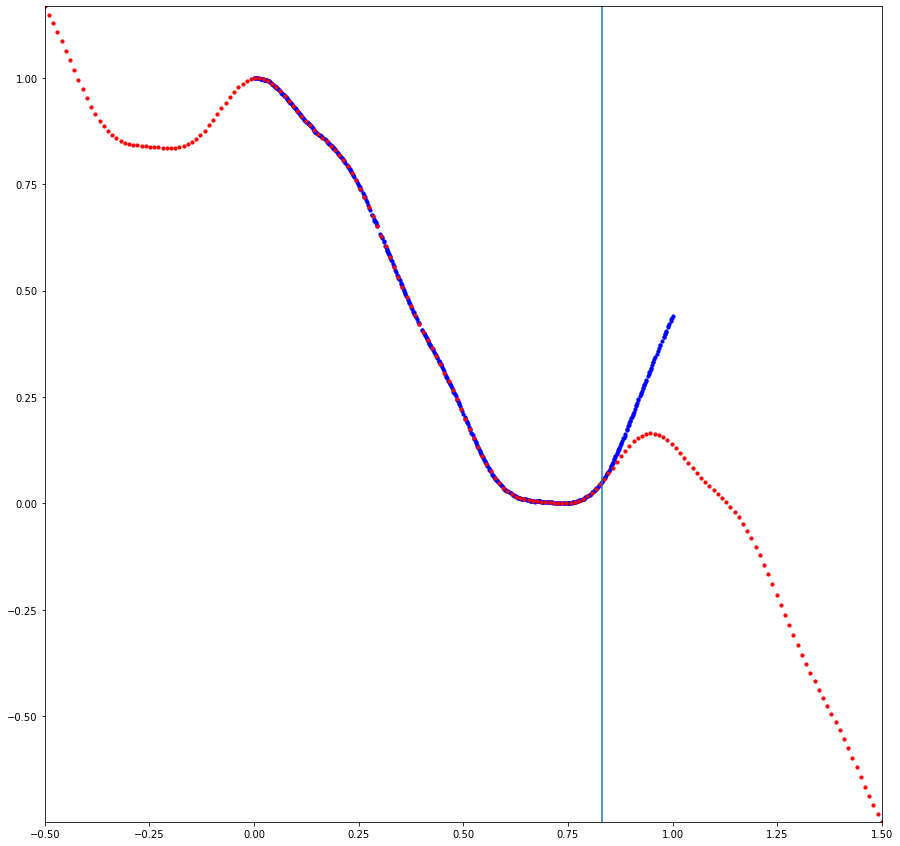

In [19]:
gpre, minmaxe, minmaxt, X, y = fereg(oi_num, addXY = True)
X_test = np.linspace(-0.5,1.5,200).reshape(-1,1)
y_pred = gpre.predict(X_test)
print(gpre.score(X, y))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X, y, c = 'blue', s = 10)
plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)
#krreg.

### fit function for angle inclination

In [20]:
#include tail fit # inclination

def fireg(oi_num, dattaili = dattail, datfiti = datfit, addXY = False):
    kernel = ExpSineSquared(length_scale = 1, periodicity = 0.1, length_scale_bounds = (1E-3, 5E0),
                            periodicity_bounds = (1E-3, 1E0)) *  C(0.1, (1e-3, 1e0)) \
            + DotProduct(sigma_0=0.01, sigma_0_bounds=(1e-05, 1e5))

    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))


    X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

    y = dfdebreg.loc[norads[oi_num]].inc.values
    ysub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].inc.values
    ysub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].inc.values
    ysub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].inc.values


    minmaxi = MinMaxScaler()
    minmaxt = MinMaxScaler()
    minmaxt.fit(X.reshape(-1, 1))
    #minmaxn.fit(np.array([1,24]).reshape(-1, 1))
    minmaxi.fit(y.reshape(-1, 1))
    y = minmaxi.transform(y.reshape(-1, 1))
    X = minmaxt.transform(X.reshape(-1, 1))
    ysub = minmaxi.transform(ysub.reshape(-1, 1))
    Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
    ysub2 = minmaxi.transform(ysub2.reshape(-1, 1))
    Xsub2 = minmaxt.transform(Xsub2.reshape(-1, 1))
    ysub3 = minmaxi.transform(ysub3.reshape(-1, 1))
    Xsub3 = minmaxt.transform(Xsub3.reshape(-1, 1))

    alphaval = [1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5,1e-6,3e-6,1e-7,3e-7,1e-8,3e-8,1e-9,3e-9,1e-10]
    errlist = list()
    for a in alphaval:
    #    break
        gpri = GaussianProcessRegressor(kernel=kernel, alpha=a, n_restarts_optimizer = 10, random_state=42)
        # first extract linear behavior, then extract oscillatory pattern, forecast
        gpri.fit(Xsub2, ysub2)
     #   y_pred = gprn.predict(Xsub3)
    #    errlist.append(mean_squared_error(ysub3, y_pred))
        errlist.append(gpri.score(Xsub3, ysub3))
        #gprn.fit(Xsub, ysub)
        #print(gprn.score(X, y))
    alpha = alphaval[np.argmax(errlist)]

    #alpha = alphaval[np.argmin(errlist)]
    #alpha = 1e-2

    #technically look for better alpha based on gradient boosting
    print(alpha)
    print(errlist)
    gpri = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer = 10, random_state=42)
    gpri.fit(Xsub, ysub)
    if addXY: return gpri, minmaxi, minmaxt, X, y
    return gpri, minmaxi, minmaxt

#X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
#y_pred = gpri.predict(X_test)
#print(gpri.score(X, y))

#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
#plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
#plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
#plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
#plt.scatter(X, y, c = 'blue', s = 10)
#plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)
#krreg.

### print of fit function for inclination

0.03
[-0.74499270807378, -0.3308568093874673, -1.3133003263384353, -1.02229455252386, -0.42275639438254253, -0.4385248254955034, -1.4017060210388617, -0.647810855716721, -2.1483141679610167, -2.1654064330413023, -4.995739808822299, -5.011106230976782, -1.6202483114724102, -1.221059445622961, -1.6202635729447628, -2.0095500641191326, -1.620264639542505]
0.7805109619062587


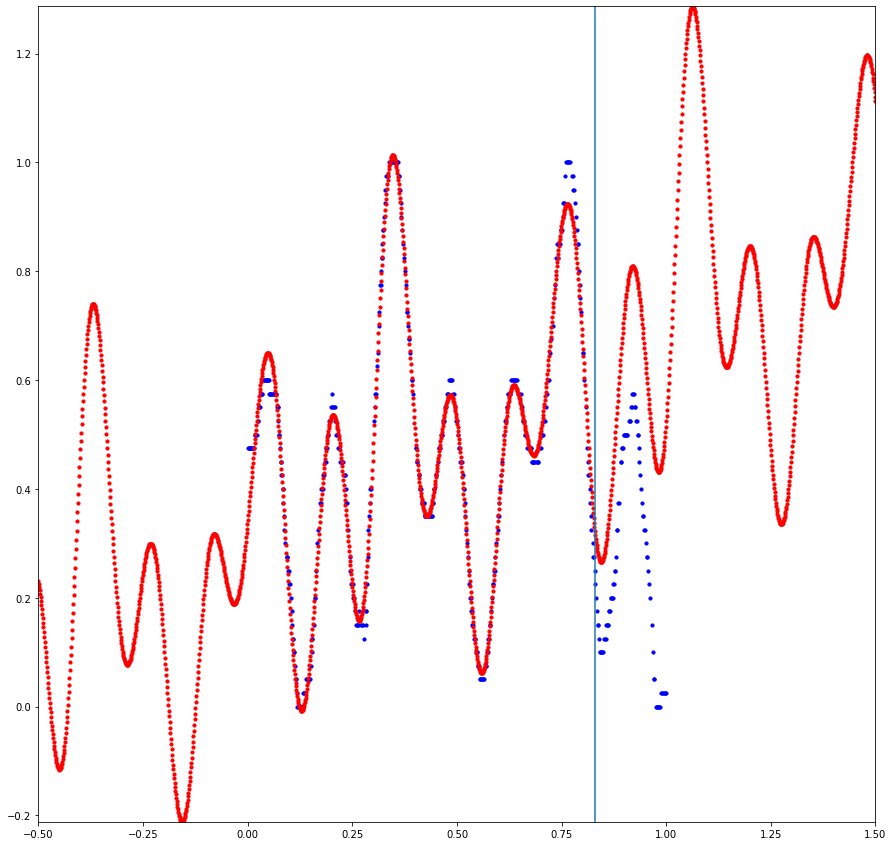

In [21]:
gpri, minmaxi, minmaxt, X, y = fireg(oi_num, addXY = True)
X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
y_pred = gpri.predict(X_test)
print(gpri.score(X, y))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X, y, c = 'blue', s = 10)
plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)
#krreg.

### fit function for angle raan (right ascension of ascending node)

In [22]:
#raan fit

def frreg(oi_num, dattaili = dattail, datfiti = datfit, addXY = False):
    # first fit base behavior then fit submodel
    ## perform curve_fit for raan
    fitfunc = lambda x, p0, p1: (p0 + p1 * x) #% 1
    # sortby datetime
    dfsub = dfdebreg.loc[norads[oi_num]].sort_values('datetimes')
    X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    X = dfsub.datetimes.apply(lambda x: x.timestamp()).values


    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)
    y = dfdebreg.loc[norads[oi_num]].raan.values
    y = dfsub.raan.values

    minmaxr = MinMaxScaler()
    minmaxt = MinMaxScaler()
    minmaxt.fit(X.reshape(-1, 1))
    minmaxr.fit(np.array([0,360]).reshape(-1, 1))
    y = minmaxr.transform(y.reshape(-1, 1))
    X = minmaxt.transform(X.reshape(-1, 1))

    # now split different regions according to distance
    boundt = 0.7 ** 2
    regions = list()#np.empty(shape = [9,2])#array()#(2,1)
    #print(regions.shape)
    sign = 1
    yc = y[0]
    # angle can go from 0 to 360 and 361 is 1 adjust this to not have any jumps in data
    for i, x in enumerate(X): # problem X is not ordered
        if(i > 0):
            dx = X[i] - X[i - 1]
            dy = y[i] - y[i - 1]
            dist = (dx ** 2 + dy ** 2)
            if dist > boundt: # do something
                print('doing', i, dist, X[i])
                #regions[i] = [X[i - 1], X[i]]
                #np.append(regions, [X[i - 1], X[i]], axis = 0)
                regions.append([X[i - 1], X[i], sign])
                yc = y[i]
            #elif dy <= 0: sign = -1 #can fail
            #else: sign = 1 
            if(y[i] - yc >= 0): sign = 1
            else: sign = -1
    Xreg = X
    ilower = 0;
    #count = 1
    for c in regions:
        for i in range(ilower, len(X)):
            if X[i] > c[0]:
                #Xreg.append
                y[i] += c[2]
                #count += c[2] 
                #pass

    # Assume sign remains constant
    #print(X[:,0])
    ymod = minmaxr.inverse_transform(y)

    #print(ymod)
    dfdebreg.loc[norads[oi_num],'raanmod'] = ymod




    kernel = ExpSineSquared(length_scale = 1, periodicity = 0.1, length_scale_bounds = (1E-7, 5E0),
                            periodicity_bounds = (1E-3, 1E1)) *  C(0.0001, (1e-8, 1e-3)) \
            + DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))
    #kernel = DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))
    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))


    #X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub = list()#dfdebreg[dfdebreg.datetimes < datfit].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub2 = list()#dfdebreg[(dfdebreg.datetimes < datfit) & (dfdebreg.datetimes >= dattail)].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub3 = list()#dfdebreg[dfdebreg.datetimes < dattail].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

    #y = dfdebreg.loc[norads[oi_num]].inc.values
    ysub = list()#dfdebreg[dfdebreg.datetimes < datfit].loc[norads[oi_num]].inc.values
    ysub2 = list()#dfdebreg[(dfdebreg.datetimes < datfit) & (dfdebreg.datetimes >= dattail)].loc[norads[oi_num]].inc.values
    ysub3 = list()#dfdebreg[dfdebreg.datetimes < dattail].loc[norads[oi_num]].inc.values

    dfit = minmaxt.transform(np.array(datfiti.timestamp()).reshape(-1,1))[0][0]
    dtail = minmaxt.transform(np.array(dattaili.timestamp()).reshape(-1,1))[0][0]

    for idx, x in enumerate(X):
        if x < dfit:
            Xsub.append(x)
            ysub.append(y[idx])
            #print(ysub[idx], y[idx])
        if x < dfit and x >= dtail:
            Xsub2.append(x)
            ysub2.append(y[idx])
        if x < dtail:
            Xsub3.append(x)
            ysub3.append(y[idx])


    #print(ysub2)
    #print(datfit.timestamp(), dattail.timestamp())

    #minmaxi = MinMaxScaler()
    #minmaxt = MinMaxScaler()
    #minmaxt.fit(X.reshape(-1, 1))
    #minmaxn.fit(np.array([1,24]).reshape(-1, 1))
    #minmaxi.fit(y.reshape(-1, 1))
    #y = minmaxi.transform(y.reshape(-1, 1))
    #X = minmaxt.transform(X.reshape(-1, 1))
    ysub = np.array(ysub)
    ysub2 = np.array(ysub2)
    ysub3 = np.array(ysub3)
    Xsub = np.array(Xsub)
    Xsub2 = np.array(Xsub2)
    Xsub3 = np.array(Xsub3)
    #ysub = minmaxi.transform(ysub.reshape(-1, 1))
    #Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
    #ysub2 = minmaxi.transform(ysub2.reshape(-1, 1))
    #Xsub2 = minmaxt.transform(Xsub2.reshape(-1, 1))
    #ysub3 = minmaxi.transform(ysub3.reshape(-1, 1))
    #Xsub3 = minmaxt.transform(Xsub3.reshape(-1, 1))

    alphaval = [1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5,1e-6,3e-6,1e-7,3e-7,1e-8,3e-8,1e-9,3e-9,1e-10]
    errlist = list()
    for a in alphaval:
    #    break
        gprr = GaussianProcessRegressor(kernel=kernel, alpha=a, n_restarts_optimizer = 10, random_state=42)
        # first extract linear behavior, then extract oscillatory pattern, forecast
        gprr.fit(Xsub2, ysub2)
     #   y_pred = gprn.predict(Xsub3)
    #    errlist.append(mean_squared_error(ysub3, y_pred))
        errlist.append(gprr.score(Xsub3, ysub3))
        #gprn.fit(Xsub, ysub)
        #print(gprn.score(X, y))
    alpha = alphaval[np.argmax(errlist)]

    #alpha = alphaval[np.argmin(errlist)]
    #alpha = 1e-2

    #technically look for better alpha based on gradient boosting
    print(alpha)
    print(errlist)
    gprr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer = 10, random_state=42)
    gprr.fit(Xsub, ysub)
    if addXY: return gprr, minmaxr, minmaxt, X, y
    return gprr, minmaxr, minmaxt
#X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
#y_pred = gprr.predict(X_test)
#y_predc = gprr.predict(X)
#print(gprr.score(X, y))

#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
#plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
#plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
#plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
#plt.scatter(X, y, c = 'blue', s = 1)
#plt.scatter(X_test, y_pred, c = 'red', s = 1)
#plt.ylim(np.min(y_predc - y),np.max(y_predc - y))
#plt.scatter(X, y_predc - y, c = 'red', s = 10)
#print(krreg.params)
#krreg.


#print(X)
#print(y_pred)
#print(ysub)
#print(y)











#X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), y,
#                                                    test_size=0.33, random_state=42)
#init = [1,-3]
#out2, cov_x2 = curve_fit(fitfunc, xdata = X_train.flatten(), ydata = y_train.flatten(), p0 = init)

#degree = 1
#poly_features = PolynomialFeatures(degree=degree)
#X_trainp = poly_features.fit_transform(X_train)
#X_testp = poly_features.fit_transform(X_test)
#print(out2)
#y_pred2 = fitfunc(X, out2[0], out2[1])
#plt.scatter(X, y_pred2 - y, c = 'blue')



#print(out2)

#y_pred = fitfunc(X_testp, out2[0], out2[1])
#krreg.fit(X_trainp[:,1].reshape(-1,1), y_train)

#y_pred = krreg.predict(X_testp)

#better  
#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#plt.xlim(0.,1.)
#plt.ylim(np.min(y_test),np.max(y_test))
#plt.ylim(np.min(y_pred2 - y),np.max(y_pred2 - y))
#plt.ylim(-6,6)
#plt.scatter(X_test, y_test.flatten(), c = 'red')
#plt.scatter(X_testp[:, 1], y_pred[:, 1], c = 'blue')
#plt.scatter(X, y, c = 'red')
#y_train
#X_testp
#X_testp[:, 1]
#y_pred[:,1]
#regions
#y_test
#X_test
#regions
#y_pred

### print of angle raan fit

doing 216 [0.98625067] [0.36412192]
doing 426 [0.98625122] [0.75869283]
3e-06
[0.9999219175982295, 0.9992984661693668, 0.9999992233634621, 0.9999929789758087, 0.9999999925695834, 0.9999999311253537, 0.9999999998011797, 0.9999999992894856, 0.999999999827233, 0.999999999832302, 0.999999999822859, 0.9999999998239495, 0.9999999998221868, 0.9999999998224238, 0.9999999998204419, 0.9999999998217131, 0.999999999190807]
0.9999999999298739


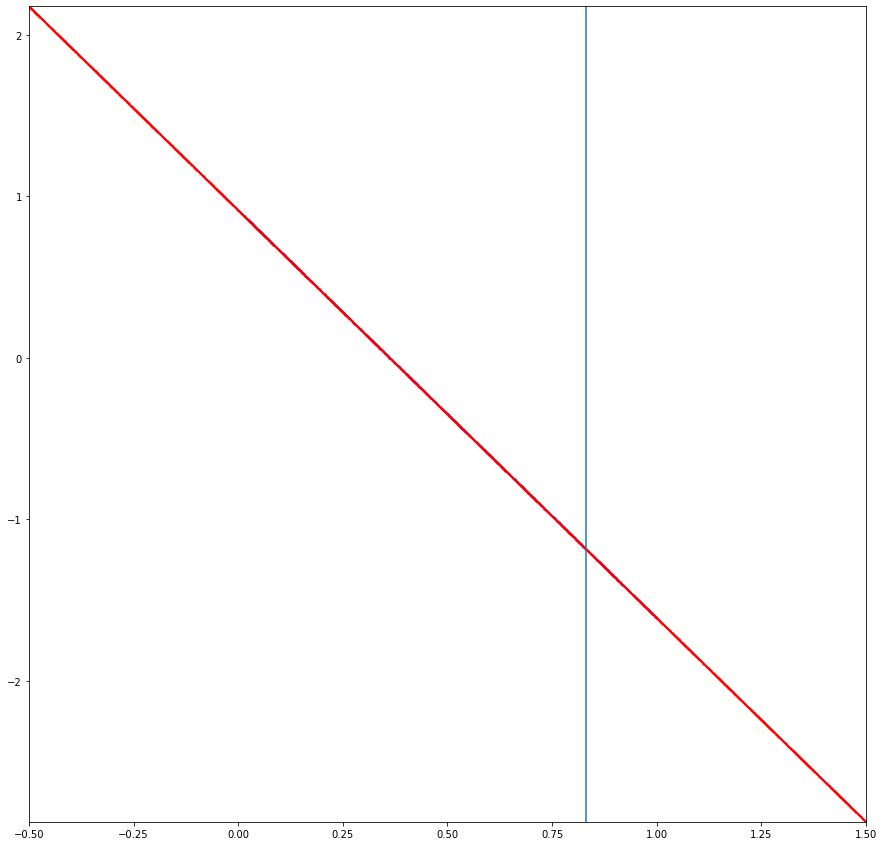

In [23]:
gprr, minmaxr, minmaxt, X, y = frreg(oi_num, addXY = True)
X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
y_pred = gprr.predict(X_test)
y_predc = gprr.predict(X)
print(gprr.score(X, y))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X, y, c = 'blue', s = 1)
plt.scatter(X_test, y_pred, c = 'red', s = 1)

### fit function for angle argp

In [24]:
#argp fit
def fareg(oi_num, dattaili = dattail, datfiti = datfit, addXY = False):

    # first fit base behavior then fit submodel
    ## perform curve_fit for argp
    fitfunc = lambda x, p0, p1: (p0 + p1 * x) #% 1
    # sortby datetime
    dfsub = dfdebreg.loc[norads[oi_num]].sort_values('datetimes')
    X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    X = dfsub.datetimes.apply(lambda x: x.timestamp()).values


    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)
    y = dfdebreg.loc[norads[oi_num]].argp.values
    y = dfsub.argp.values

    minmaxa = MinMaxScaler()
    minmaxt = MinMaxScaler()
    minmaxt.fit(X.reshape(-1, 1))
    minmaxa.fit(np.array([0,360]).reshape(-1, 1))
    y = minmaxa.transform(y.reshape(-1, 1))
    X = minmaxt.transform(X.reshape(-1, 1))

    # now split different regions according to distance
    boundt = 0.7 ** 2
    regions = list()#np.empty(shape = [9,2])#array()#(2,1)
    #print(regions.shape)
    sign = 1
    yc = y[0]
    for i, x in enumerate(X): # problem X is not ordered
        if(i > 0):
            dx = X[i] - X[i - 1]
            dy = y[i] - y[i - 1]
            dist = (dx ** 2 + dy ** 2)
            if dist > boundt: # do something
                print('doing', i, dist, X[i])
                #regions[i] = [X[i - 1], X[i]]
                #np.append(regions, [X[i - 1], X[i]], axis = 0)
                regions.append([X[i - 1], X[i], sign])
                yc = y[i]
            #elif dy <= 0: sign = -1 #can fail
            #else: sign = 1 
            if(y[i] - yc >= 0): sign = 1
            else: sign = -1
    Xreg = X
    ilower = 0;
    #count = 1
    for c in regions:
        for i in range(ilower, len(X)):
            if X[i] > c[0]:
                #Xreg.append
                y[i] += c[2]
                #count += c[2] 
                #pass

    # Assume sign remains constant
    #print(X[:,0])
    ymod = minmaxa.inverse_transform(y)

    #print(ymod)
    dfdebreg.loc[norads[oi_num],'argpmod'] = ymod




    kernel = ExpSineSquared(length_scale = 1, periodicity = 0.1, length_scale_bounds = (1E-3, 5E0),
                            periodicity_bounds = (1E-3, 1E1)) *  C(0.01, (1e-8, 1e-0)) \
            + DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))
    #kernel = DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))
    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))


    #X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub = list()#dfdebreg[dfdebreg.datetimes < datfit].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub2 = list()#dfdebreg[(dfdebreg.datetimes < datfit) & (dfdebreg.datetimes >= dattail)].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub3 = list()#dfdebreg[dfdebreg.datetimes < dattail].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

    #y = dfdebreg.loc[norads[oi_num]].inc.values
    ysub = list()#dfdebreg[dfdebreg.datetimes < datfit].loc[norads[oi_num]].inc.values
    ysub2 = list()#dfdebreg[(dfdebreg.datetimes < datfit) & (dfdebreg.datetimes >= dattail)].loc[norads[oi_num]].inc.values
    ysub3 = list()#dfdebreg[dfdebreg.datetimes < dattail].loc[norads[oi_num]].inc.values

    dfit = minmaxt.transform(np.array(datfiti.timestamp()).reshape(-1,1))[0][0]
    dtail = minmaxt.transform(np.array(dattaili.timestamp()).reshape(-1,1))[0][0]

    for idx, x in enumerate(X):
        if x < dfit:
            Xsub.append(x)
            ysub.append(y[idx])
            #print(ysub[idx], y[idx])
        if x < dfit and x >= dtail:
            Xsub2.append(x)
            ysub2.append(y[idx])
        if x < dtail:
            Xsub3.append(x)
            ysub3.append(y[idx])


    #print(ysub2)
    #print(datfit.timestamp(), dattail.timestamp())

    #minmaxi = MinMaxScaler()
    #minmaxt = MinMaxScaler()
    #minmaxt.fit(X.reshape(-1, 1))
    #minmaxn.fit(np.array([1,24]).reshape(-1, 1))
    #minmaxi.fit(y.reshape(-1, 1))
    #y = minmaxi.transform(y.reshape(-1, 1))
    #X = minmaxt.transform(X.reshape(-1, 1))
    ysub = np.array(ysub)
    ysub2 = np.array(ysub2)
    ysub3 = np.array(ysub3)
    Xsub = np.array(Xsub)
    Xsub2 = np.array(Xsub2)
    Xsub3 = np.array(Xsub3)
    #ysub = minmaxi.transform(ysub.reshape(-1, 1))
    #Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
    #ysub2 = minmaxi.transform(ysub2.reshape(-1, 1))
    #Xsub2 = minmaxt.transform(Xsub2.reshape(-1, 1))
    #ysub3 = minmaxi.transform(ysub3.reshape(-1, 1))
    #Xsub3 = minmaxt.transform(Xsub3.reshape(-1, 1))

    alphaval = [1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5,1e-6,3e-6,1e-7,3e-7,1e-8,3e-8,1e-9,3e-9,1e-10]
    errlist = list()
    for a in alphaval:
    #    break
        gpra = GaussianProcessRegressor(kernel=kernel, alpha=a, n_restarts_optimizer = 10, random_state=42)
        # first extract linear behavior, then extract oscillatory pattern, forecast
        gpra.fit(Xsub2, ysub2)
     #   y_pred = gprn.predict(Xsub3)
    #    errlist.append(mean_squared_error(ysub3, y_pred))
        errlist.append(gpra.score(Xsub3, ysub3))
        #gprn.fit(Xsub, ysub)
        #print(gprn.score(X, y))
    alpha = alphaval[np.argmax(errlist)]

    #alpha = alphaval[np.argmin(errlist)]
    #alpha = 1e-2

    #technically look for better alpha based on gradient boosting
    print(alpha)
    print(errlist)
    gpra = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer = 10, random_state=42)
    gpra.fit(Xsub, ysub)
    if addXY: return gpra, minmaxa, minmaxt, X, y
    return gpra, minmaxa, minmaxt
#X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
#y_pred = gpra.predict(X_test)
#y_predc = gpra.predict(X)
#print(gpra.score(X, y))

#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
#plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
#plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
#plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
#plt.scatter(X, y, c = 'blue', s = 1)
#plt.scatter(X_test, y_pred, c = 'red', s = 1)
#plt.ylim(np.min(y_predc - y),np.max(y_predc - y))
#plt.scatter(X, y_predc - y, c = 'red', s = 10)
#print(krreg.params)
#krreg.


#print(X)
#print(y_pred)
#print(ysub)
#print(y)











#X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), y,
#                                                    test_size=0.33, random_state=42)
#init = [1,-3]
#out2, cov_x2 = curve_fit(fitfunc, xdata = X_train.flatten(), ydata = y_train.flatten(), p0 = init)

#degree = 1
#poly_features = PolynomialFeatures(degree=degree)
#X_trainp = poly_features.fit_transform(X_train)
#X_testp = poly_features.fit_transform(X_test)
#print(out2)
#y_pred2 = fitfunc(X, out2[0], out2[1])
#plt.scatter(X, y_pred2 - y, c = 'blue')



#print(out2)

#y_pred = fitfunc(X_testp, out2[0], out2[1])
#krreg.fit(X_trainp[:,1].reshape(-1,1), y_train)

#y_pred = krreg.predict(X_testp)

#better  
#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#plt.xlim(0.,1.)
#plt.ylim(np.min(y_test),np.max(y_test))
#plt.ylim(np.min(y_pred2 - y),np.max(y_pred2 - y))
#plt.ylim(-6,6)
#plt.scatter(X_test, y_test.flatten(), c = 'red')
#plt.scatter(X_testp[:, 1], y_pred[:, 1], c = 'blue')
#plt.scatter(X, y, c = 'red')
#y_train
#X_testp
#X_testp[:, 1]
#y_pred[:,1]
#regions
#y_test
#X_test
#regions
#y_pred

### plot of fit function for angle argp

0.0003
[0.9156283049147134, 0.8941372100407237, 0.996921754716545, 0.9774444616473845, 0.9990600971675967, 0.9995699595856592, 0.9938426572632842, 0.9970922198712335, 0.9755641145243835, 0.9868467812180488, 0.9786394248790347, 0.9750857801609495, 0.9832978334642258, 0.9815307104748127, 0.9849006985657068, 0.9849086775721818, 0.8759521297212025]
0.9998062088774523


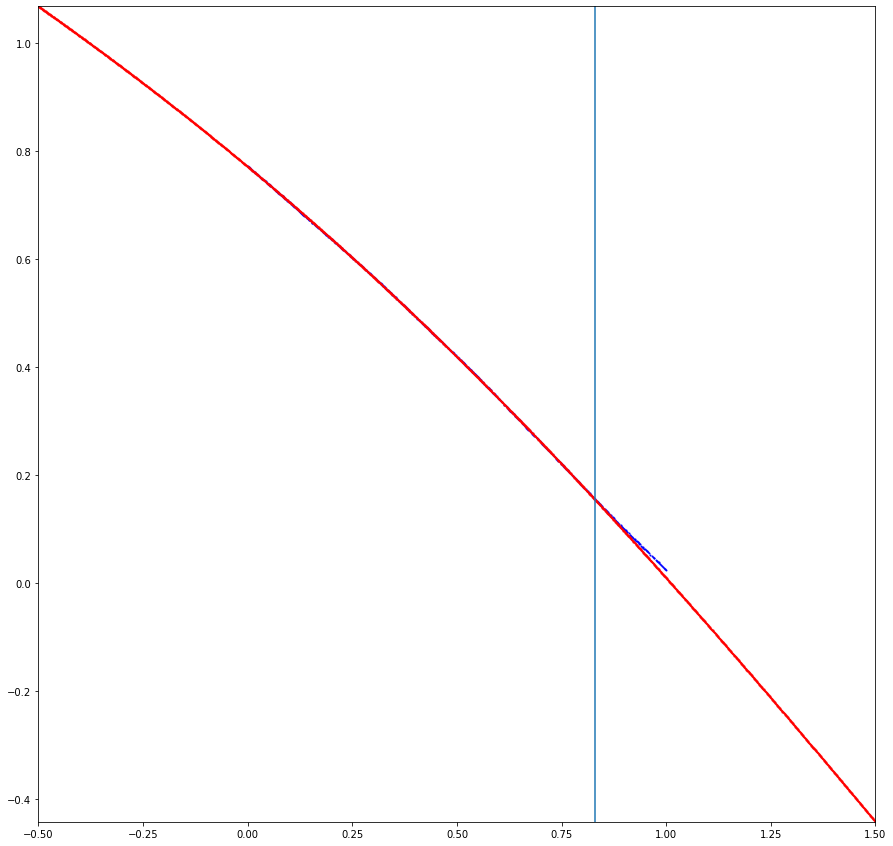

In [25]:
gpra, minmaxa, minmaxt, X, y = fareg(oi_num, addXY = True)
X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
y_pred = gpra.predict(X_test)
y_predc = gpra.predict(X)
print(gpra.score(X, y))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X, y, c = 'blue', s = 1)
plt.scatter(X_test, y_pred, c = 'red', s = 1)
#plt.ylim(np.min(y_predc - y),np.max(y_predc - y))
#plt.scatter(X, y_predc - y, c = 'red', s = 10)
#print(krreg.params)
#krreg.

In [79]:
minmaxa.inverse_transform(np.array(1).reshape(1,-1))-minmaxa.inverse_transform(np.array(0).reshape(1,-1))

array([[360.]])

# Modeling of angle m
Now, we model m using a simple baseline model and study fluctuations:

This angle varies very rapidly i.e. between different datapoints several revolution may have occurred, so a direct fit is practically useless, rather we define a baseline model that corresponds to the time integrated revolution number and then we study the  deviations which can be several as small as 0.2° but as large as several 10°.

In [26]:
# import for integration
import scipy.integrate as integrate

In [27]:
# funcition that we want to integrate
def nfunc(t):
    #t = minmaxt.inverse_transform(t)
    return minmaxn.inverse_transform(gprn.predict(np.array(t).reshape(1,-1)))[0][0]

In [28]:
dfdebreg.loc[norads[oi_num]].tail(50).head(1).m.values[0]

325.7789

In [29]:
# some transformed example time
te = minmaxt.transform(np.array([dfdebreg.loc[norads[oi_num]].tail(50).head(1).datetimes.values[0].timestamp()]).reshape(1,-1))


In [30]:
# mean anomaly (m) calc
# integrate 360 * n over time n in terms of sec is n = n'/(24*3600)   gprn
# int n'(t)/240 dt, minmaxn, minmaxt
delt = minmaxt.inverse_transform(np.array([0,1]).reshape(1,-1))[0]
delt = delt[1] - delt[0]
t = 1
print(integrate.quad(nfunc, 0, te)[1] / 240 * delt)
# expression for integration, will be used later
(integrate.quad(nfunc, 0, te)[0] / 240 * delt + dfdebreg.loc[norads[oi_num]].m.values[0]) % 360
#dfdebreg.loc[norads[oi_num]].m.values[0]
#nfunc(0)
#minmaxn.inverse_transform(np.array([0,1]).reshape(1,-1))[0][1]

1.2665437211734905e-06


323.40185541752726

Note a deviation of about 3°

In [31]:
# integrated baseline angles m for times X
ymm = [(integrate.quad(nfunc, 0, x)[0] / 240 * delt + dfdebreg.loc[norads[oi_num]].m.values[0]) % 360 for x in X]

### fit function for variations in angle m with respect to the above estimate

In [32]:
#include tail fit # m

def fmreg(oi_num, minmaxt, dattaili = dattail, datfiti = datfit, addXY = False, gprn = gprn, minmaxn = minmaxn):
    kernel = ExpSineSquared(length_scale = 1, periodicity = 0.01, length_scale_bounds = (1E-3, 5E1),
                            periodicity_bounds = (1E-3, 1E0)) *  C(0.1, (1e-4, 1e0)) \
            + DotProduct(sigma_0=1, sigma_0_bounds=(1e-05, 1e5))

    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))


    X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub = dfdebreg[dfdebreg.datetimes < datfit].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub2 = dfdebreg[(dfdebreg.datetimes < datfit) & (dfdebreg.datetimes >= dattail)].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub3 = dfdebreg[dfdebreg.datetimes < dattail].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

    y = dfdebreg.loc[norads[oi_num]].m.values
    ysub = dfdebreg[dfdebreg.datetimes < datfit].loc[norads[oi_num]].m.values
    ysub2 = dfdebreg[(dfdebreg.datetimes < datfit) & (dfdebreg.datetimes >= dattail)].loc[norads[oi_num]].m.values
    ysub3 = dfdebreg[dfdebreg.datetimes < dattail].loc[norads[oi_num]].m.values

    minmaxt = MinMaxScaler()
    minmaxt.fit(X.reshape(-1, 1))
    X = minmaxt.transform(X.reshape(-1, 1))
    Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
    Xsub2 = minmaxt.transform(Xsub2.reshape(-1, 1))
    Xsub3 = minmaxt.transform(Xsub3.reshape(-1, 1))
    

    delt = minmaxt.inverse_transform(np.array([0,1]).reshape(1,-1))[0]
    delt = delt[1] - delt[0]
    #t = 1
    #print(integrate.quad(nfunc, 0, te)[1] / 240 * delt)
    #X[:,0]
    
    def nfunc(t):
    #t = minmaxt.inverse_transform(t)
        return minmaxn.inverse_transform(gprn.predict(np.array(t).reshape(1,-1)))[0][0]
    
    ymm = np.array([(integrate.quad(nfunc, 0, x)[0] / 240. * delt + dfdebreg.loc[norads[oi_num]].m.values[0]) % 360. for x in X]).reshape(1,-1)
    ymms = np.array([(integrate.quad(nfunc, 0, x)[0] / 240. * delt + dfdebreg.loc[norads[oi_num]].m.values[0]) % 360. for x in Xsub]).reshape(1,-1)
    ymms2 = np.array([(integrate.quad(nfunc, 0, x)[0] / 240. * delt + dfdebreg.loc[norads[oi_num]].m.values[0]) % 360. for x in Xsub2]).reshape(1,-1)
    ymms3 = np.array([(integrate.quad(nfunc, 0, x)[0] / 240. * delt + dfdebreg.loc[norads[oi_num]].m.values[0]) % 360. for x in Xsub3]).reshape(1,-1)
    
    # take into account fluctuations about 0 and 360
    yh = y - ymm
    yhs = ysub - ymms
    yhs2 = ysub2 - ymms2
    yhs3 = ysub3 - ymms3
   # print(y)
    #print(ymm)
    for idx, xi in np.ndenumerate(yh):
      #  print(xi)
        if xi > 180: yh[idx] = xi - 360 
        elif xi < -180: yh[idx] = xi + 360 
    for idx, xi in np.ndenumerate(yhs):
        if xi > 180: yhs[idx] = xi - 360 
        elif xi < -180: yhs[idx] = xi + 360 
    for idx, xi in np.ndenumerate(yhs2):
        if xi > 180: yhs2[idx] = xi - 360 
        elif xi < -180: yhs2[idx] = xi + 360 
    for idx, xi in np.ndenumerate(yhs3):
        if xi > 180: yhs3[idx] = xi - 360 
        elif xi < -180: yhs3[idx] = xi + 360 

    minmaxm = MinMaxScaler()
    #minmaxn.fit(np.array([1,24]).reshape(-1, 1))
    minmaxm.fit(yh.reshape(-1, 1))
    yh = minmaxm.transform(yh.reshape(-1, 1))
    yhs = minmaxm.transform(yhs.reshape(-1, 1))
    yhs2 = minmaxm.transform(yhs2.reshape(-1, 1))
    yhs3 = minmaxm.transform(yhs3.reshape(-1, 1))

    alphaval = [1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5,1e-6,3e-6,1e-7,3e-7,1e-8,3e-8,1e-9,3e-9,1e-10]
    errlist = list()
    for a in alphaval:
    #    break
        gprm = GaussianProcessRegressor(kernel=kernel, alpha=a, n_restarts_optimizer = 10, random_state=42)
        # first extract linear behavior, then extract oscillatory pattern, forecast
        gprm.fit(Xsub2, yhs2)
        #y_pred = gprm.predict(Xsub3)
        #errlist.append(mean_squared_error(yhs3, y_pred))
        errlist.append(gprm.score(Xsub3, yhs3))
        #gprn.fit(Xsub, ysub)
        #print(gprn.score(X, y))
    alpha = alphaval[np.argmax(errlist)]

    #alpha = alphaval[np.argmin(errlist)]
    #alpha = 1e-2

    #technically look for better alpha based on gradient boosting
    print(alpha)
    print(errlist)
    gprm = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer = 10, random_state=42)
    gprm.fit(Xsub, yhs)
    if addXY: return gprm, minmaxm, X, yh
    return gprm, minmaxm
#X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
#y_pred = gprm.predict(X_test)
#print(gprm.score(X, yh))

#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
#plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
#plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
#plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
#plt.scatter(X, yh, c = 'blue', s = 10)
#plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)
#krreg.

### plot of variations of angle m with respect to baseline with fit

0.01
[0.27601256618730496, -0.47081414772694735, -1.3516070050243725, -1.1563072551800286, -1.0359827661123968, -1.1225897579502986, -1.7350486178192293, -1.3349472802105953, -1.8775232462065718, -1.9233282950718023, -11.766368275434836, -11.288439621171431, -16.66527281137844, -13.99706396688979, -21.85623536752595, -22.680631932622163, -32.081979428682516]
0.9688750265265579


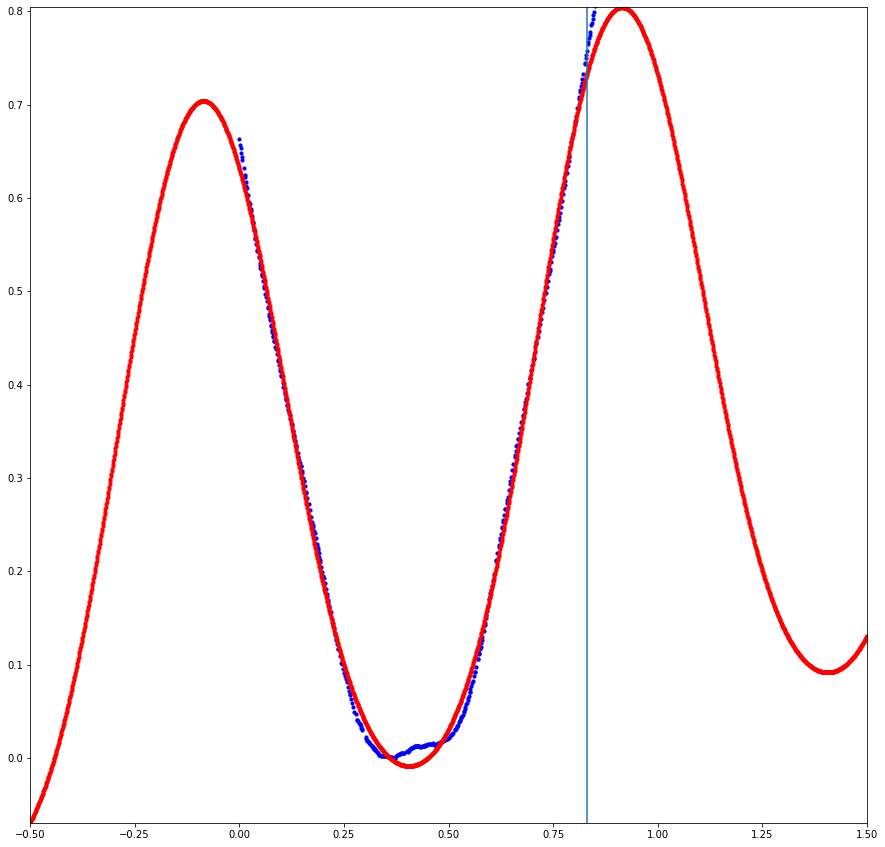

In [33]:
gprm, minmaxm, X, yh = fmreg(oi_num, minmaxt = minmaxt, addXY = True)
X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
y_pred = gprm.predict(X_test)
print(gprm.score(X, yh))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X, yh, c = 'blue', s = 10)
plt.scatter(X_test, y_pred, c = 'red', s = 10)

In [82]:
print(minmaxm.inverse_transform(np.array(1).reshape(1,-1)) - minmaxm.inverse_transform(np.array(0).reshape(1,-1)))

[[9.912765]]


### Function that calculates value of m given fluctuations and approximation

In [35]:
def mpred(Xin, minmaxm, gprm):
    return np.add(minmaxm.inverse_transform(gprm.predict(Xin)), \
            np.array([(integrate.quad(nfunc, 0, x)[0] / 240 * delt \
                       + dfdebreg.loc[norads[oi_num]].m.values[0]) for x in Xin]).reshape(len(Xin),-1)) % 360
            #+ integrate.quad(nfunc, 0, Xin)[0] / 240 * delt \
            #+ dfdebreg.loc[norads[oi_num]].m.values[0]) % 360

In [36]:
Xl = [1,0.5,0]
Xan = np.array(Xl).reshape(len(Xl),-1)
#mpred(Xan, gprm = gprm, minmaxm = minmaxm)[:,0]
#np.array([1,0.5]).reshape(2,-1)
#minmaxm.inverse_transform(gprm.predict(Xan))
np.array([(integrate.quad(nfunc, 0, x)[0] / 240 * delt \
                       + dfdebreg.loc[norads[oi_num]].m.values[0]) % 360 for x in Xan]).reshape(len(Xan),-1) 
#Xan

array([[348.10162863],
       [203.44277038],
       [ 81.0546    ]])

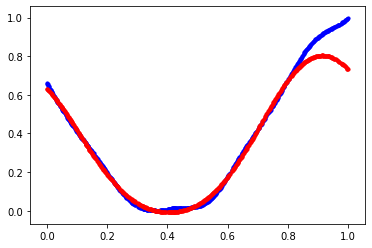

In [37]:
plt.scatter(X, yh, c = 'blue', s = 10)
y_pred11 = gprm.predict(X)
plt.scatter(X, y_pred11, c = 'red', s = 10)

In [38]:
dfdebreg.head()

m     argp     bstar     dn_o2       ecc      inc  \
norad date                                                                    
119   2018.916314  270.3322  90.8959  0.000116  0.000002  0.009762  66.7291   
      2018.918618  270.9942  90.2340  0.000132  0.000002  0.009762  66.7292   
      2018.920538  271.5473  89.6810  0.000139  0.000002  0.009764  66.7292   
      2018.921690  271.8807  89.3476  0.000145  0.000003  0.009765  66.7292   
      2018.924762  272.7554  88.4725  0.000146  0.000003  0.009766  66.7293   

                           n      raan                   datetimes  \
norad date                                                           
119   2018.916314  14.231530  321.6569  2018-12-02 07:54:00.447264   
      2018.918618  14.231535  319.4778  2018-12-03 04:08:23.052480   
      2018.920538  14.231539  317.6620  2018-12-03 21:00:21.864672   
      2018.921690  14.231542  316.5724  2018-12-04 07:07:33.134016   
      2018.924762  14.231550  313.6672  2018-12-05 10:06:43.134336   

                             x            y            z  raanmod  argpmod  
norad date                                                                  
119   2018.916314 -4901.525329  1282.372903 -5189.980904      NaN      NaN  
      2018.918618 -4848.810102  1466.583764 -5191.453009      NaN      NaN  
      2018.920538 -4802.750196  1624.538882 -5187.783987      NaN      NaN  
      2018.921690 -4769.396965  1712.059910 -5190.812972      NaN      NaN  
      2018.924762 -4677.366596  1952.818559 -5190.482112      NaN      NaN

## Fit function to forecast bstar (radiation feedback)

In [39]:
#include tail fit # bstar

def fbreg(oi_num, dattaili = dattail, datfiti = datfit, addXY = False):
    kernel = ExpSineSquared(length_scale = 1, periodicity = 0.01, length_scale_bounds = (1E-3, 5E1),
                            periodicity_bounds = (1E-3, 1E0)) *  C(0.1, (1e-3, 1e0)) \
            + DotProduct(sigma_0=1, sigma_0_bounds=(1e-05, 1e5))

    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))


    X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

    y = dfdebreg.loc[norads[oi_num]].bstar.values
    ysub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].bstar.values
    ysub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].bstar.values
    ysub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].bstar.values


    minmaxb = MinMaxScaler()
    minmaxt = MinMaxScaler()
    minmaxt.fit(X.reshape(-1, 1))
    #minmaxn.fit(np.array([1,24]).reshape(-1, 1))
    minmaxb.fit(y.reshape(-1, 1))
    y = minmaxb.transform(y.reshape(-1, 1))
    X = minmaxt.transform(X.reshape(-1, 1))
    ysub = minmaxb.transform(ysub.reshape(-1, 1))
    Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
    ysub2 = minmaxb.transform(ysub2.reshape(-1, 1))
    Xsub2 = minmaxt.transform(Xsub2.reshape(-1, 1))
    ysub3 = minmaxb.transform(ysub3.reshape(-1, 1))
    Xsub3 = minmaxt.transform(Xsub3.reshape(-1, 1))

    alphaval = [1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5,1e-6,3e-6,1e-7,3e-7,1e-8,3e-8,1e-9,3e-9,1e-10]
    errlist = list()
    for a in alphaval:
    #    break
        gprb = GaussianProcessRegressor(kernel=kernel, alpha=a, n_restarts_optimizer = 10, random_state=42)
        # first extract linear behavior, then extract oscillatory pattern, forecast
        gprb.fit(Xsub2, ysub2)
    #    y_pred = gprb.predict(Xsub3)
    #    errlist.append(mean_squared_error(ysub3, y_pred))
        errlist.append(gprb.score(Xsub3, ysub3))
        #gprn.fit(Xsub, ysub)
        #print(gprn.score(X, y))
    alpha = alphaval[np.argmax(errlist)]

    #alpha = alphaval[np.argmin(errlist)]
    #alpha = 1e-2

    #technically look for better alpha based on gradient boosting
    print(alpha)
    print(errlist)
    gprb = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer = 10, random_state=42)
    gprb.fit(Xsub, ysub)
    if addXY: return gprb, minmaxb, X, y
    return gprb, minmaxb
#X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
#y_pred = gprb.predict(X_test)
#print(gprb.score(X, y))

#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
#plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
#plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
#plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
#plt.scatter(X, y, c = 'blue', s = 10)
#plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)
#krreg.

### Plot fit function for bstar

0.001
[-0.27582671892682886, -0.48116821660193687, -0.08780878643637591, -0.2998824506315807, -1.2370263938219197, -0.5666117310874763, -0.5380882074462854, -0.40744177208586524, -3.2945457693510214, -2.671324751414139, -1.8552326097292686, -1.8914545902762436, -2.1055099148108143, -1.9717394800953185, -3.4048814404324457, -1.2138622915188817, -4.4136792508783556]
0.8989661821236806


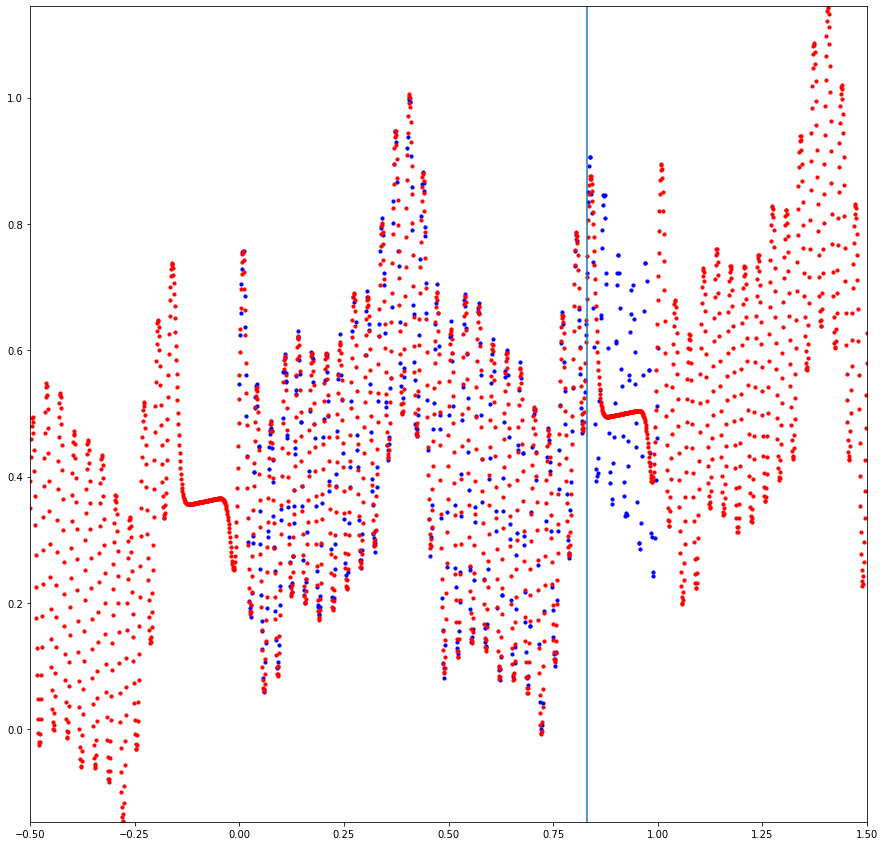

In [40]:
gprb, minmaxb, X, y = fbreg(oi_num, addXY = True)
X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
y_pred = gprb.predict(X_test)
print(gprb.score(X, y))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X, y, c = 'blue', s = 10)
plt.scatter(X_test, y_pred, c = 'red', s = 10)

## Fit function for dn_o2 (derivative of n with respect to time)

In [41]:
#include tail fit # dn_o2

def fdreg(oi_num, dattaili = dattail, datfiti = datfit, addXY = False):
    kernel = ExpSineSquared(length_scale = 1, periodicity = 0.01, length_scale_bounds = (1E-4, 5E1),
                            periodicity_bounds = (1E-4, 1E0)) *  C(0.1, (1e-3, 1e0)) \
            + DotProduct(sigma_0=1, sigma_0_bounds=(1e-03, 1e3))

    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))


    X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
    Xsub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

    #X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

    y = dfdebreg.loc[norads[oi_num]].dn_o2.values
    ysub = dfdebreg[dfdebreg.datetimes < datfiti].loc[norads[oi_num]].dn_o2.values
    ysub2 = dfdebreg[(dfdebreg.datetimes < datfiti) & (dfdebreg.datetimes >= dattaili)].loc[norads[oi_num]].dn_o2.values
    ysub3 = dfdebreg[dfdebreg.datetimes < dattaili].loc[norads[oi_num]].dn_o2.values


    minmaxdn = MinMaxScaler()
    minmaxt = MinMaxScaler()
    minmaxt.fit(X.reshape(-1, 1))
    #minmaxn.fit(np.array([1,24]).reshape(-1, 1))
    minmaxdn.fit(y.reshape(-1, 1))
    y = minmaxdn.transform(y.reshape(-1, 1))
    X = minmaxt.transform(X.reshape(-1, 1))
    ysub = minmaxdn.transform(ysub.reshape(-1, 1))
    Xsub = minmaxt.transform(Xsub.reshape(-1, 1))
    ysub2 = minmaxdn.transform(ysub2.reshape(-1, 1))
    Xsub2 = minmaxt.transform(Xsub2.reshape(-1, 1))
    ysub3 = minmaxdn.transform(ysub3.reshape(-1, 1))
    Xsub3 = minmaxt.transform(Xsub3.reshape(-1, 1))

    alphaval = [1e-2,3e-2,1e-3,3e-3,1e-4,3e-4,1e-5,3e-5,1e-6,3e-6,1e-7,3e-7,1e-8,3e-8,1e-9,3e-9,1e-10]
    errlist = list()
    for a in alphaval:
    #    break
        gprdn = GaussianProcessRegressor(kernel=kernel, alpha=a, n_restarts_optimizer = 10, random_state=42)
        # first extract linear behavior, then extract oscillatory pattern, forecast
        gprdn.fit(Xsub2, ysub2)
      #  y_pred = gprdn.predict(Xsub3)
      #  errlist.append(mean_squared_error(ysub3, y_pred))
        errlist.append(gprdn.score(Xsub3, ysub3))
        #gprn.fit(Xsub, ysub)
        #print(gprn.score(X, y))
    alpha = alphaval[np.argmax(errlist)]

    #alpha = alphaval[np.argmin(errlist)]
    #alpha = 1e-2

    #technically look for better alpha based on gradient boosting
    print(alpha)
    print(errlist)
    gprdn = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer = 10, random_state=42)
    gprdn.fit(Xsub, ysub)
    if addXY: return gprdn, minmaxdn, X, y
    return gprdn, minmaxdn
#X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
#y_pred = gprdn.predict(X_test)
#print(gprdn.score(X, y))

#print(r2_score(y_test, y_pred))

#ax = plt.figure(figsize = (15,15))
#lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
#plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
#plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
#plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
#plt.scatter(X, y, c = 'blue', s = 10)
#plt.scatter(X_test, y_pred, c = 'red', s = 10)
#print(krreg.params)
#krreg.

### Plot of fit function for dn_o2

0.003
[-0.14527278786467845, -0.633780964611566, -0.0898319246914856, -0.0658391982168196, -1.2464030532710884, -0.5781056584821092, -0.49444690789787216, -0.4231721317367141, -2.2884107009857453, -3.1344719890436883, -1.5037005499702971, -2.146009177356412, -0.8086051214921008, -3.14271214423158, -1.4136350227991006, -1.4512941124419196, -2.1337616835788378]
0.8991470539227742


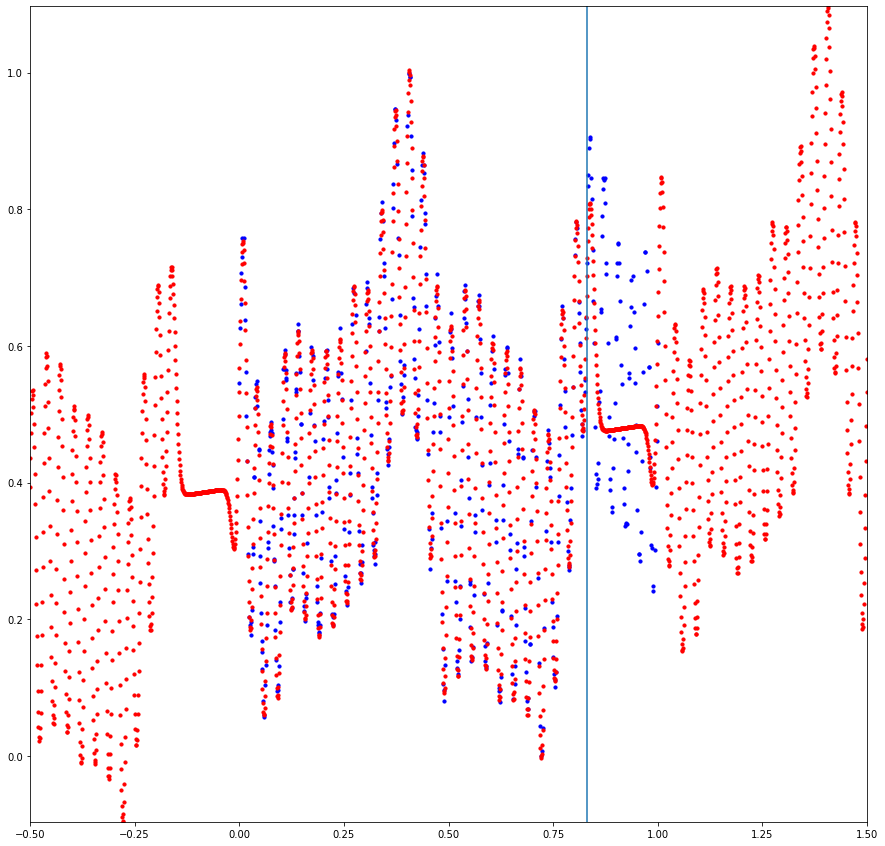

In [42]:
gprdn, minmaxdn, X, y = fdreg(oi_num, addXY = True)
X_test = np.linspace(-0.5,1.5,2000).reshape(-1,1)
y_pred = gprdn.predict(X_test)
print(gprdn.score(X, y))

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
lti = minmaxt.transform(np.array(datfit.timestamp()).reshape(-1,1))[0][0]
#print(lti)
plt.plot([lti, lti], [-10, 10])#, transform=ax.transAxes)
plt.xlim(-0.5,1.5)
#plt.xlim(-0.,0.25)
plt.ylim(np.min(y_pred),np.max(y_pred))
#plt.ylim(np.min(y_test-y_pred),np.max(y_test-y_pred))
#plt.scatter(X_test, y_test-y_pred, c = 'red')
plt.scatter(X, y, c = 'blue', s = 10)
plt.scatter(X_test, y_pred, c = 'red', s = 10)

In [43]:
# now sort out all important quanities and develop class, adjust line1, line2 params

In [44]:
# checkup
# X needs to be transformed
minmaxn.inverse_transform(gprn.predict(X)), minmaxe.inverse_transform(gpre.predict(X)), \
            minmaxi.inverse_transform(gpri.predict(X)), minmaxr.inverse_transform(gprr.predict(X)) % 360,\
            minmaxa.inverse_transform(gpra.predict(X)) % 360, mpred(X, minmaxm, gprm) % 360,\
            minmaxb.inverse_transform(gprb.predict(X)), minmaxdn.inverse_transform(gprdn.predict(X))

(array([[14.05420297],
        [14.05420397],
        [14.05420446],
        [14.05420532],
        [14.05420597],
        [14.0542066 ],
        [14.05420781],
        [14.05420896],
        [14.05420927],
        [14.05421005],
        [14.05421057],
        [14.05421108],
        [14.05421205],
        [14.05421304],
        [14.0542133 ],
        [14.05421398],
        [14.05421422],
        [14.05421475],
        [14.05421543],
        [14.0542156 ],
        [14.0542163 ],
        [14.0542163 ],
        [14.05421707],
        [14.05421722],
        [14.05421776],
        [14.05421828],
        [14.05421842],
        [14.05421902],
        [14.05421907],
        [14.0542197 ],
        [14.05421988],
        [14.0542201 ],
        [14.05422032],
        [14.05422071],
        [14.05422079],
        [14.05422092],
        [14.05422139],
        [14.05422191],
        [14.05422208],
        [14.05422268],
        [14.0542229 ],
        [14.05422333],
        [14.0542239 ],
        [14

In [46]:
#checkup
#(X, minmaxm, gprm) % 360 # need to adjust mpred

In [47]:
#generate lines l1, l2

### Detecting numericals

In [48]:
def isnumeric(x):
    try: 
        float(x)
        return True
    except:
        return False

In [49]:
print(isnumeric('a'), isnumeric('1'), isnumeric('.'), isnumeric('+'), isnumeric(' '))

False True False False False


#### checksum modulo 10

In [50]:
ltest = '1     5U 58002B   19292.92671750 +.00000171 +00000-0 +22506-3 0  9997'

def checksum(line):
    csum = 0
    for x in range(len(line) - 1):
        if isnumeric(line[x]):
            csum += int(line[x])
        if line[x] == '-': csum += 1
    return csum % 10

#### set + sign as string for positive numbers

In [51]:
def setsign(inputa):
    inputa = str(inputa)
    if float(inputa) < 0: return ''
    else: return '+'

In [52]:
checksum(ltest)
ltest[18:20]

'19'

In [53]:
str(datetime.fromtimestamp(minmaxt.inverse_transform(X)[-1,0]).year)[-2:]

'19'

In [54]:
datetime.fromtimestamp(minmaxt.inverse_transform(X)[-1,0])

datetime.datetime(2019, 12, 1, 15, 9, 44, 59680)

In [55]:
print(dfdeb_m.head().line1.values)
dfdeb_m.head().bstar.values

['1 00119U 61015D   18335.37083851 +.00000192 +00000-0 +11600-3 0  9992'
 '1 00119U 61015D   18336.21415570 +.00000230 +00000-0 +13189-3 0  9990'
 '1 00119U 61015D   18336.91691973 +.00000246 +00000-0 +13881-3 0  9996'
 '1 00119U 61015D   18337.33857794 +.00000262 +00000-0 +14544-3 0  9993'
 '1 00119U 61015D   18338.46299924 +.00000263 +00000-0 +14575-3 0  9998']


array([0.000116  , 0.00013189, 0.00013881, 0.00014544, 0.00014575])

In [56]:
# checking out formatting tricks
tap = 0.000116
ntap = math.ceil(np.log(tap) / np.log(10))
str(tap)[2 - ntap:]

'116'

In [57]:
# checking out transformations
a = datetime.fromtimestamp(minmaxt.inverse_transform(X)[-1,0]) - datetime(year = datetime.fromtimestamp(minmaxt.inverse_transform(X)[-1,0]).year, month = 1, day = 1)
days = a.days + a.seconds / (3600 * 24) + a.microseconds / (3600 * 24 * 1000 * 1000)
days
#a


334.63175995

## transform data for sgp4 models with calculated orbit parameters

In [58]:


ltest = '1     5U 58002B   19292.92671750 +.00000171 +00000-0 +22506-3 0  9997'
# given old line1 and line2, produce new for time x

# params as n, ecc, inc, raan, argp, m, bstar, dn_o2
# extract year from time and perform timedelta in days
def line1gen_new(line1, params, time): # time as datetime
    #line1 modify range wise
    
    #19-20 year digits
    #21-32 day 3 . 8 digits
    #34-43 dn_o2 sign . 8 digits
    #45-52 dn_o6 sign 5 digits - mag
    #54-61 bstar sign 5 digits - mag
    #69 checksum of string
    linelist = [x for x in line1]
    linelist[18:20] = str(time.year)[-2:]
    # there is a mistake of exactly one hour no idea why! introduce additional
    daytime = time - datetime(year = time.year, month = 1, day = 1, hour = 0, minute = 0, second = 0)
    #daytime -= timedelta(hours = 1)
    days = (daytime.days + (daytime.seconds + daytime.microseconds / 1e6) / (3600 * 24))
    # technically insufficient
    daysd = str(int(days - days % 1))
    while len(daysd) < 3: daysd = '0' + daysd
    days = daysd + str(float(days % 1))[1:]
    while len(daysd) < 12: daysd += '0'
    linelist[20:32] = str(days)[:12]
    f'{params[7]:.8f}'
    dno2s = setsign(params[7]) + f'{params[7]:.8f}'[1:]#str(float(params[7]))[1:]
    while len(dno2s) < 10: dno2s += '0'
    linelist[33:43] = dno2s[:10]
    #print(params[7], linelist[33:43])
    bstars = params[6]
    ntap = 0
    if(bstars > 0):
        ntap = math.ceil(np.log(bstars) / np.log(10))
    digitstr = str(bstars)[2 - ntap:]
    bstarsstr = str(bstars)
    while len(digitstr) < 5: digitstr += '0'
    linelist[53:61] = (setsign(bstars) + digitstr[:5] + str(ntap))[:8]
    line1 = ""
    for x in linelist:
        line1 += x
    csum = checksum(line1)
    linelist[68] = str(csum)
    line1 = ""
    for x in linelist:
        line1 += x
    return line1

#line1 = ('1 00005U 58002B   00179.78495062  '
#         '.00000023  00000-0  28098-4 0  4753')
#1     5U 58002B   19292.92671750 +.00000171 +00000-0 +22506-3 0  9997

In [59]:
params = [14, 0.1, 10, 100, 130, 76, 0.000134, 0.0001267]
time = datetime.fromtimestamp(minmaxt.inverse_transform(X)[-1,0])
print(line1gen_new(ltest, params, time))
print(ltest)

1     5U 58002B   19334.63175995 +.00012670 +00000-0 +13400-3 0  9992
1     5U 58002B   19292.92671750 +.00000171 +00000-0 +22506-3 0  9997


In [60]:
ltest2 = '2     5 034.2474 252.3331 1842730 345.5028 009.8881 10.84775502179024'

# params as n, ecc, inc, raan, argp, m, bstar, dn_o2
def line2gen_new(line2, params, time):
    #linelist = [x for x in line1]
    #line1 = ""
    #for x in linelist:
    #    line1 += x
    
    #9-16 inc 3.4
    #18-25 raan 3.4
    #27-33 ecc 7
    #35-42 argp 3.4
    #44-51 m 3.4
    #53-63 n 2.8
    #64-68 rev num ignore
    #69 checksum 
    
    linelist = [x for x in line2]
    # inc params[2]
    incd = str(int(params[2] - params[2] % 1))
    while len(incd) < 3: incd = '0' + incd
    incd = str(incd) + str(float(params[2] % 1))[1:]
    while len(incd) < 8: incd += '0'
    linelist[8:16] = incd[:8]
    
    # raan params[3]
    raand = str(int(params[3] - params[3] % 1))
    while len(raand) < 3: raand = '0' + raand
    raand = str(raand) + str(float(params[3] % 1))[1:]
    while len(raand) < 8: raand += '0'
    linelist[17:25] = raand[:8]
    
    # argp params[4]
    argpd = str(int(params[4] - params[4] % 1))
    while len(argpd) < 3: argpd = '0' + argpd
    argpd = str(argpd) + str(float(params[4] % 1))[1:]
    while len(argpd) < 8: argpd += '0'
    linelist[34:42] = argpd[:8]
    
    # m params[5]
    md = str(int(params[5] - params[5] % 1))
    while len(md) < 3: md = '0' + md
    md = str(md) + str(float(params[5] % 1))[1:]
    while len(md) < 8: md += '0'
    linelist[43:51] = md[:8]
    
    eccp = str(params[1])[2:]
    while len(eccp) < 7: eccp += '0'
    linelist[26:33] = eccp[:7]
    
    # n params[0]
    nd = str(int(params[0] - params[0] % 1))
    while len(nd) < 2: nd = '0' + nd
    nd = str(nd) + str(float(params[0] % 1))[1:]
    while len(nd) < 11: nd += '0'
    linelist[52:63] = nd[:11]
    
    line2 = ""
    for x in linelist:
        line2 += x
    csum = checksum(line2)
    linelist[68] = str(csum)
    line2 = ""
    for x in linelist:
        line2 += x
    return line2
    
#line2 = ('2 00005  34.2682 348.7242 1859667 '
#         '331.7664  19.3264 10.82419157413667')
#2     5 034.2474 252.3331 1842730 345.5028 009.8881 10.84775502179024

In [61]:
params = [14, 0.1, 10, 100, 130, 76, 0.000134, 0.0001267]
time = datetime.fromtimestamp(minmaxt.inverse_transform(X)[-1,0])
print(line2gen_new(ltest2, params, time))
print(ltest2)

2     5 010.0000 100.0000 1000000 130.0000 076.0000 14.00000000179021
2     5 034.2474 252.3331 1842730 345.5028 009.8881 10.84775502179024


In [64]:
#line1 = []
#xyz_model(line1, line2, date):
#coordcalt(line1, line2, date):

In [65]:
print(line1gen_new(dfdeb_m.loc[norads[oi_num]].line1.values[0], params, time))
print(dfdeb_m.loc[norads[oi_num]].line1.values[0])

1 00125U 61015K   19334.63175995 +.00012670 +00000-0 +13400-3 0  9993
1 00125U 61015K   18335.14086647 +.00000054 +00000-0 +79971-4 0  9993


In [66]:
print(line2gen_new(dfdeb_m.loc[norads[oi_num]].line2.values[0], params, time))
print(dfdeb_m.loc[norads[oi_num]].line2.values[0])

2 00125 010.0000 100.0000 1000000 130.0000 076.0000 14.00000000930401
2 00125 066.8765 329.0796 0081233 278.1332 081.0546 14.05419712930401


In [67]:
params = [x.flatten()[0] for x in oi_pred.predict(np.array(X[-1,0]).reshape(1,-1))]
time = datetime.fromtimestamp(minmaxt.inverse_transform(X)[-1,0])
l1 = line1gen_new(dfdeb_m.loc[norads[oi_num]].line1.values[0], params, time)
l2 = line2gen_new(dfdeb_m.loc[norads[oi_num]].line2.values[0], params, time)
print(xyz_model(l1, l2, time))
print(params, l1 ,l2)
print(f'{params[7]:.8f}')

NameError: name 'oi_pred' is not defined

In [68]:
#dfdeb_m.loc[norads[oi_num]].line1.values[0]
#dfdeb_m.loc[norads[oi_num]].line2.values[0]

## Class for orbit predictions of given objects according to their number oi_num

In [ ]:
# now sort out all important quantities and develop class, adjust line1, line2 params

In [69]:
class oi_predictor:
    def __init__(self, oi):
        gprn, minmaxn, minmaxt = fnreg(oi)
        gpre, minmaxe, minmaxt = fereg(oi)
        gpri, minmaxi, minmaxt = fireg(oi)
        gprr, minmaxr, minmaxt = frreg(oi)
        gpra, minmaxa, minmaxt = fareg(oi)
        gprm, minmaxm = fmreg(oi, minmaxt = minmaxt, gprn = gprn, minmaxn = minmaxn) # use mpred(Xin, minmaxm, gprm)
        gprb, minmaxb = fbreg(oi)
        gprdn, minmaxdn = fdreg(oi)
    def predict(self, X):
        return minmaxn.inverse_transform(gprn.predict(X)), minmaxe.inverse_transform(gpre.predict(X)), \
            minmaxi.inverse_transform(gpri.predict(X)), minmaxr.inverse_transform(gprr.predict(X)) % 360,\
            minmaxa.inverse_transform(gpra.predict(X)) % 360, mpred(X, minmaxm, gprm) % 360,\
            minmaxb.inverse_transform(gprb.predict(X)), minmaxdn.inverse_transform(gprdn.predict(X))
    def calcoord(self, X):
        params = [x.flatten()[0] for x in oi_pred.predict(np.array(X[-1,0]).reshape(1,-1))]
        time = datetime.fromtimestamp(minmaxt.inverse_transform(X)[-1,0])
        l1 = line1gen_new(dfdeb_m.loc[norads[oi_num]].line1.values[0], params, time)
        l2 = line2gen_new(dfdeb_m.loc[norads[oi_num]].line2.values[0], params, time)
        return xyz_model(l1, l2, time)

In [70]:
oi_pred = oi_predictor(oi_num)

0.001
[-0.9891129522207773, -0.8445762290389294, 0.8185682243897998, -1.001100846037895, 0.7283376403391082, 0.5048861658813038, -10.649310527088613, -9.402892022078227, -4.171957088886562, -2.535216658461436, -5.620492259634485, -4.027757125510736, -4.406103370298348, -6.217022003497814, -5.3614716326613445, -0.2881787008533445, -0.2972534486280203]
0.001
3e-06
[0.4604612920793667, 0.619783492185789, -7.661944875363735, 0.4282264927748358, -7.01606853229957, -7.8684190656981325, -5.315683307177373, -6.627519303230486, -4.967421891390799, 0.6933962414299408, -7.720156755031775, -0.28909282708167905, -1.7978737610119824, -8.2983927754313, -1.471255431714262, 0.27346697968812594, 0.29539139277730586]
0.03
[-0.7449926279906208, -0.33085680937829864, -1.313300326345408, -1.0222945525044715, -0.4227045417185147, -0.43852482394324066, -1.4017120562164282, -0.6478108552750965, -2.148339710812161, -2.1654064330413023, -1.3915871350809699, -5.011106230976782, -1.6202457621790967, -1.22105944562

In [75]:
params = [x.flatten()[0] for x in oi_pred.predict(np.array(X[-1,0]).reshape(1,-1))]
time = datetime.fromtimestamp(minmaxt.inverse_transform(X)[-1,0])
l1 = line1gen_new(dfdeb_m.loc[norads[oi_num]].line1.values[0], params, time)
l2 = line2gen_new(dfdeb_m.loc[norads[oi_num]].line2.values[0], params, time)
linea = dfdeb_m.loc[norads[oi_num]].line1.values[-1]
lineb = dfdeb_m.loc[norads[oi_num]].line2.values[-1]
print(linea)
print(l1)
print(lineb)
print(l2)
predX = oi_pred.calcoord(X)
print(oi_pred.calcoord(X))
#print(xyz_model(l1, l2, time))
print(xyz_model(linea, lineb, time))
#print(params, l1 ,l2)
#print(f'{params[7]:.8f}')

1 00125U 61015K   19334.63175995 +.00000079 +00000-0 +94713-4 0  9990
1 00125U 61015K   19334.63175995 +.00000100 +00000-0 +11727-3 0  9998
2 00125 066.8747 139.9626 0073731 008.7973 351.4386 14.05487887981627
2 00125 066.8767 139.9713 0069670 003.4701 348.7775 14.05481766930405
(-5580.616263132589, 4367.646230829213, 1293.6657811307834)
(-5639.789143646111, 3903.054952870278, 2190.904997332225)


In [ ]:
## improve eccentricity and angle forecast (argp, m)

In [1914]:
a = datetime.fromtimestamp(minmaxt.inverse_transform(X)[-1])
(a.hour - 1)/ (24)

0.625

In [1879]:
(19334.67342661 - 19334.63175995) * 24

0.9999998399871401

In [1930]:
datfit

datetime.datetime(2019, 10, 1, 0, 0)

In [1931]:
dfdeb_m.head()

m     argp     bstar  ddn_o6     dn_o2       ecc  \
norad date                                                                   
119   2018.916314  270.3322  90.8959  0.000116     0.0  0.000002  0.009762   
      2018.918618  270.9942  90.2340  0.000132     0.0  0.000002  0.009762   
      2018.920538  271.5473  89.6810  0.000139     0.0  0.000002  0.009764   
      2018.921690  271.8807  89.3476  0.000145     0.0  0.000003  0.009765   
      2018.924762  272.7554  88.4725  0.000146     0.0  0.000003  0.009766   

                    epoch_day  epoch_year      inc int_desig          n  \
norad date                                                                
119   2018.916314  335.370839        2018  66.7291    61015D  14.231530   
      2018.918618  336.214156        2018  66.7292    61015D  14.231535   
      2018.920538  336.916920        2018  66.7292    61015D  14.231539   
      2018.921690  337.338578        2018  66.7292    61015D  14.231542   
      2018.924762  338.462999        2018  66.7293    61015D  14.231550   

                       raan  rev_num  \
norad date                             
119   2018.916314  321.6569    96598   
      2018.918618  319.4778    96653   
      2018.920538  317.6620    96620   
      2018.921690  316.5724    96626   
      2018.924762  313.6672    96685   

                                                               line1  \
norad date                                                             
119   2018.916314  1 00119U 61015D   18335.37083851 +.00000192 +0...   
      2018.918618  1 00119U 61015D   18336.21415570 +.00000230 +0...   
      2018.920538  1 00119U 61015D   18336.91691973 +.00000246 +0...   
      2018.921690  1 00119U 61015D   18337.33857794 +.00000262 +0...   
      2018.924762  1 00119U 61015D   18338.46299924 +.00000263 +0...   

                                                               line2  \
norad date                                                             
119   2018.916314  2 00119 066.7291 321.6569 0097618 090.8959 270...   
      2018.918618  2 00119 066.7292 319.4778 0097624 090.2340 270...   
      2018.920538  2 00119 066.7292 317.6620 0097637 089.6810 271...   
      2018.921690  2 00119 066.7292 316.5724 0097647 089.3476 271...   
      2018.924762  2 00119 066.7293 313.6672 0097665 088.4725 272...   

                   object_id        object_name country  period  inclination  \
norad date                                                                     
119   2018.916314  1961-015D  THOR ABLESTAR DEB      US  101.18        66.73   
      2018.918618  1961-015D  THOR ABLESTAR DEB      US  101.18        66.73   
      2018.920538  1961-015D  THOR ABLESTAR DEB      US  101.18        66.73   
      2018.921690  1961-015D  THOR ABLESTAR DEB      US  101.18        66.73   
      2018.924762  1961-015D  THOR ABLESTAR DEB      US  101.18        66.73   

                   apogee  perigee rcs_size      launch  debc          apo  \
norad date                                                                   
119   2018.916314   891.0    738.0   MEDIUM  1961-06-29  True  7263.061488   
      2018.918618   891.0    738.0   MEDIUM  1961-06-29  True  7263.064188   
      2018.920538   891.0    738.0   MEDIUM  1961-06-29  True  7263.072171   
      2018.921690   891.0    738.0   MEDIUM  1961-06-29  True  7263.078315   
      2018.924762   891.0    738.0   MEDIUM  1961-06-29  True  7263.088551   

                          peri                   datetimes            x  \
norad date                                                                
119   2018.916314  7122.631233  2018-12-02 08:54:00.447264  1193.468954   
      2018.918618  7122.625332  2018-12-03 05:08:23.052480   273.176198   
      2018.920538  7122.614640  2018-12-03 22:00:21.864672  -136.651913   
      2018.921690  7122.606420  2018-12-04 08:07:33.134016  -530.784596   
      2018.924762  7122.590813  2018-12-05 11:06:43.134336  -550.232623   

                            

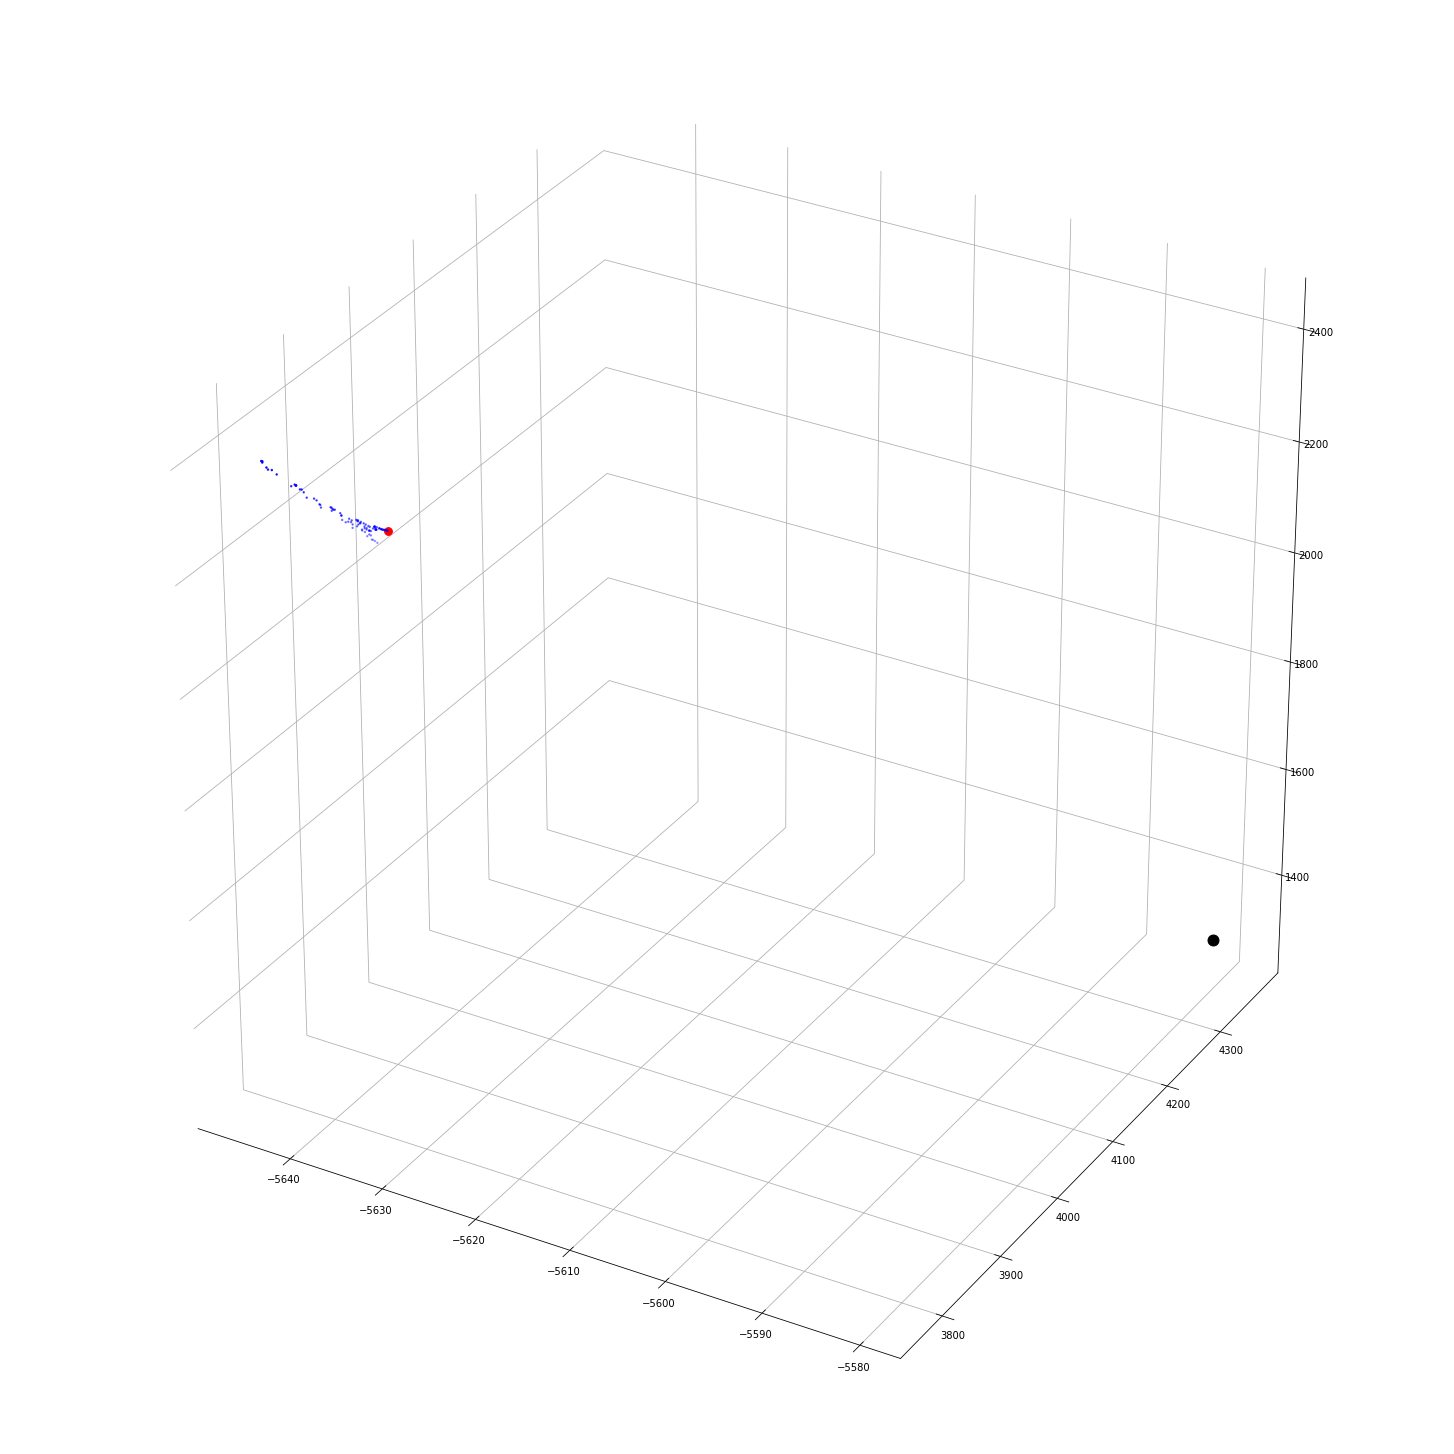

In [74]:
fig = plt.figure(figsize = (20,20))
#ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
#ax.set_xlim3d(np.min(xa), np.max(xa))
#ax.set_ylim3d(np.min(ya), np.max(ya))
#ax.set_zlim3d(np.min(za), np.max(za))
#ax.scatter(xcon, ycon, zcon, s = 0.2) 
b = 19
dfdeb_m_sub2 = dfdeb_m[dfdeb_m.datetimes > datfit]
xa, ya, za = coordcalt(dfdeb_m_sub2.loc[norads[oi_num]].line1.values, dfdeb_m_sub2.loc[norads[oi_num]].line2.values, time)
ax.scatter(xa, ya, za, s = 2, c = 'blue')
ax.scatter(xa[-1], ya[-1], za[-1], c = 'red', s = 60)
ax.scatter(predX[0], predX[1], predX[2], c = 'black', s = 120)

In [83]:
oi_num_b = 10

In [ ]:
oi_pred2 = oi_predictor(oi_num_b)

In [ ]:
params = [x.flatten()[0] for x in oi_pred2.predict(np.array(X[-1,0]).reshape(1,-1))]
time = datetime.fromtimestamp(minmaxt.inverse_transform(X)[-1,0])
l1 = line1gen_new(dfdeb_m.loc[norads[oi_num]].line1.values[0], params, time)
l2 = line2gen_new(dfdeb_m.loc[norads[oi_num]].line2.values[0], params, time)
linea = dfdeb_m.loc[norads[oi_num]].line1.values[-1]
lineb = dfdeb_m.loc[norads[oi_num]].line2.values[-1]
print(linea)
print(l1)
print(lineb)
print(l2)
predX = oi_pred2.calcoord(X)
print(oi_pred2.calcoord(X))
#print(xyz_model(l1, l2, time))
print(xyz_model(linea, lineb, time))
#print(params, l1 ,l2)
#print(f'{params[7]:.8f}')




fig = plt.figure(figsize = (20,20))
#ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
#ax.set_xlim3d(np.min(xa), np.max(xa))
#ax.set_ylim3d(np.min(ya), np.max(ya))
#ax.set_zlim3d(np.min(za), np.max(za))
#ax.scatter(xcon, ycon, zcon, s = 0.2) 
#b = 19
dfdeb_m_sub2 = dfdeb_m[dfdeb_m.datetimes > datfit]
xa, ya, za = coordcalt(dfdeb_m_sub2.loc[norads[oi_num]].line1.values, dfdeb_m_sub2.loc[norads[oi_num]].line2.values, time)
ax.scatter(xa, ya, za, s = 2, c = 'blue')
ax.scatter(xa[-1], ya[-1], za[-1], c = 'red', s = 60)
ax.scatter(predX[0], predX[1], predX[2], c = 'black', s = 120)

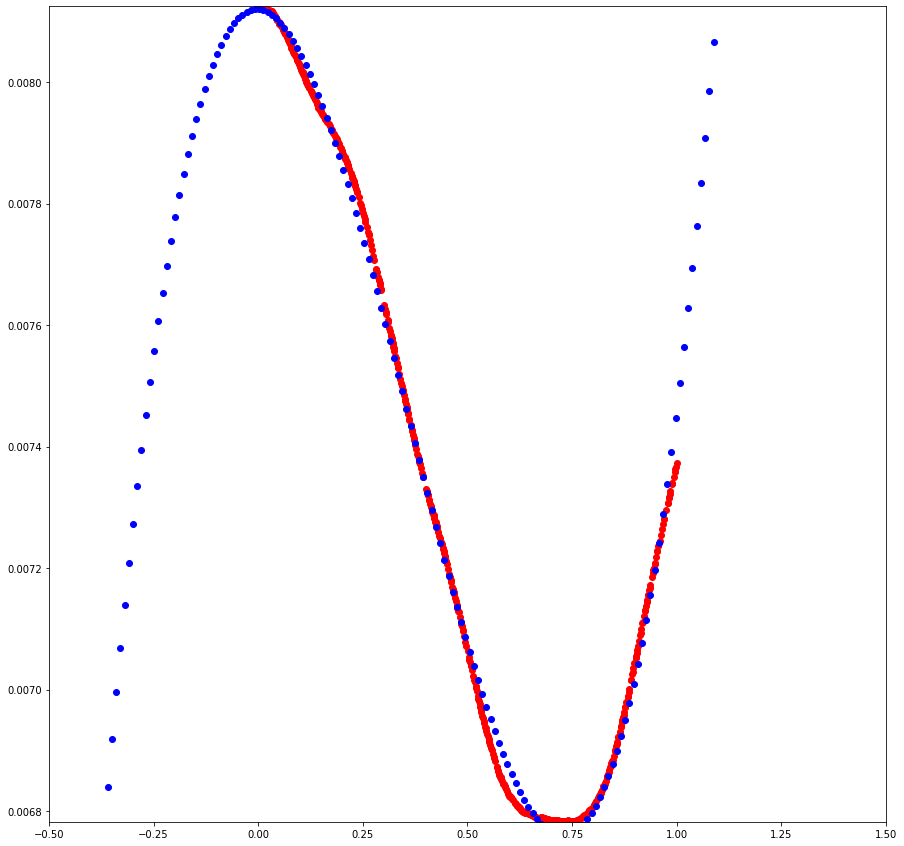

In [1384]:
kernel = ExpSineSquared(length_scale = 100, periodicity = 0.5, length_scale_bounds = (1E-3, 1E5),
                        periodicity_bounds = (1E-4, 1E3)) * DotProduct(sigma_0=1., sigma_0_bounds=(1e-05, 1e5))# \
#krreg = KernelRidge(alpha=0.00000001, kernel=kernel, gamma='linear', degree=5, coef0=1, kernel_params=None)

krreg = GaussianProcessRegressor(kernel=kernel, alpha=0.0000001)
0

X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

#X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

y = dfdebreg.loc[norads[oi_num]].ecc.values

minmaxe = MinMaxScaler()
minmaxt = MinMaxScaler()
minmaxt.fit(X.reshape(-1, 1))
minmaxe.fit(np.array([0,1]).reshape(-1, 1))
y = minmaxe.transform(y.reshape(-1, 1))
X = minmaxt.transform(X.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), y,
                                                    test_size=0.33, random_state=42)
X_train = X
X_test = X
y_train = y
y_test = y
X_trainp = X_train
X_testp = X_test
X_testb = np.linspace(-0.5,1.5,200).reshape(-1,1)

#degree = 1
#poly_features = PolynomialFeatures(degree=degree)
#X_trainp = poly_features.fit_transform(X_train)
#X_testp = poly_features.fit_transform(X_test)
krreg.fit(X_trainp, y_train)

#y_pred = krreg.predict(X_testp)
y_pred = krreg.predict(X_testb)

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
plt.xlim(-0.5,1.5)
plt.ylim(np.min(y_test),np.max(y_test))
plt.scatter(X_test, y_test, c = 'red')
plt.scatter(X_testb, y_pred, c = 'blue')
# better oscillatory interpolation

0.10300066739558611


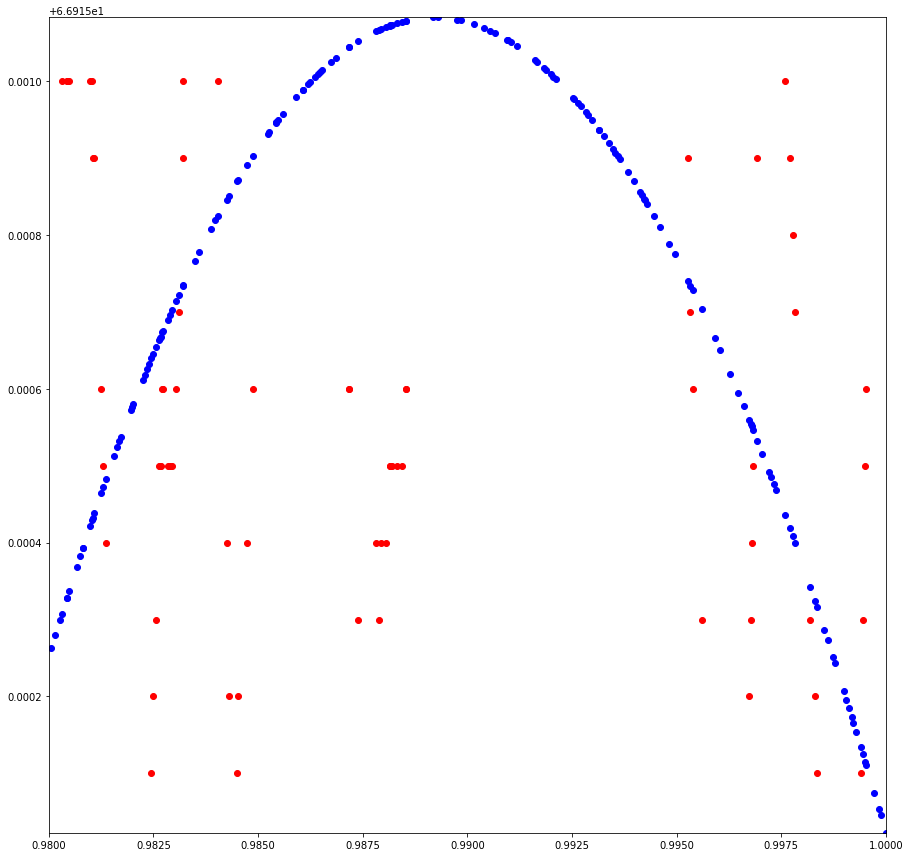

In [1285]:
#treereg = DecisionTreeRegressor(criterion = 'mae', max_depth = 8, min_samples_split = 2, min_samples_leaf = 1)
X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), dfdebreg.loc[norads[oi_num]].inc.values,
                                                    test_size=0.33, random_state=42)

degree = 1
poly_features = PolynomialFeatures(degree=degree)
X_trainp = poly_features.fit_transform(X_train)
X_testp = poly_features.fit_transform(X_test)
krreg.fit(X_trainp, y_train)

y_pred = krreg.predict(X_testp)

print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
plt.xlim(0.98,1)
plt.ylim(np.min(y_pred),np.max(y_pred))
plt.scatter(X_test, y_test, c = 'red')
plt.scatter(X_test, y_pred, c = 'blue')
# better fourier series interpolation

doing 178 [0.98610989] [0.31258292]
doing 365 [0.97723729] [0.7021832]
[ 0.79593093 -2.56733706]
[ 0.79593093 -2.56733706]


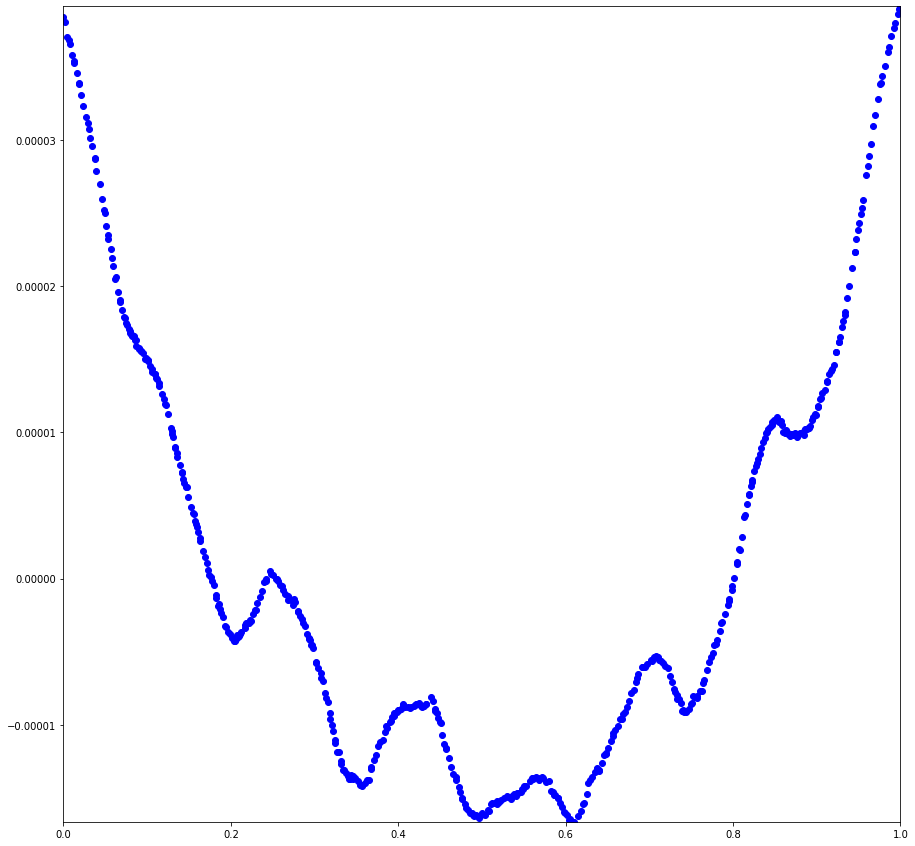

In [1286]:
#curve_fit fit of function

## perform curve_fit for raan
fitfunc = lambda x, p0, p1: (p0 + p1 * x) #% 1
# sortby datetime
dfsub = dfdebreg.loc[norads[oi_num]].sort_values('datetimes')
X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values
X = dfsub.datetimes.apply(lambda x: x.timestamp()).values


#X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)
y = dfdebreg.loc[norads[oi_num]].raan.values
y = dfsub.raan.values

minmaxang = MinMaxScaler()
minmaxt = MinMaxScaler()
minmaxt.fit(X.reshape(-1, 1))
minmaxang.fit(np.array([0,360]).reshape(-1, 1))
y = minmaxang.transform(y.reshape(-1, 1))
X = minmaxt.transform(X.reshape(-1, 1))

# now split different regions according to distance
boundt = 0.7 ** 2
regions = list()#np.empty(shape = [9,2])#array()#(2,1)
#print(regions.shape)
sign = 1
yc = y[0]
for i, x in enumerate(X): # problem X is not ordered
    if(i > 0):
        dx = X[i] - X[i - 1]
        dy = y[i] - y[i - 1]
        dist = (dx ** 2 + dy ** 2)
        if dist > boundt: # do something
            print('doing', i, dist, X[i])
            #regions[i] = [X[i - 1], X[i]]
            #np.append(regions, [X[i - 1], X[i]], axis = 0)
            regions.append([X[i - 1], X[i], sign])
            yc = y[i]
        #elif dy <= 0: sign = -1 #can fail
        #else: sign = 1 
        if(y[i] - yc >= 0): sign = 1
        else: sign = -1
Xreg = X
ilower = 0;
#count = 1
for c in regions:
    for i in range(ilower, len(X)):
        if X[i] > c[0]:
            #Xreg.append
            y[i] += c[2]
            #count += c[2] 
            #pass
            
# Assume sign remains constant
#print(X[:,0])


X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), y,
                                                    test_size=0.33, random_state=42)
init = [1,-3]
out2, cov_x2 = curve_fit(fitfunc, xdata = X_train.flatten(), ydata = y_train.flatten(), p0 = init)
print(out2)

degree = 1
poly_features = PolynomialFeatures(degree=degree)
X_trainp = poly_features.fit_transform(X_train)
X_testp = poly_features.fit_transform(X_test)
krreg.fit(X_trainp[:,1].reshape(-1,1), y_train)

#y_pred = krreg.predict(X_testp)
print(out2)
y_pred = fitfunc(X_testp, out2[0], out2[1])
y_pred2 = fitfunc(X, out2[0], out2[1])
#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
plt.xlim(0.,1.)
#plt.ylim(np.min(y_test),np.max(y_test))
plt.ylim(np.min(y_pred2 - y),np.max(y_pred2 - y))
#plt.ylim(-6,6)
#plt.scatter(X_test, y_test.flatten(), c = 'red')
#plt.scatter(X_testp[:, 1], y_pred[:, 1], c = 'blue')
#plt.scatter(X, y, c = 'red')
plt.scatter(X, y_pred2 - y, c = 'blue')
#better  
#y_train
#X_testp
#X_testp[:, 1]
#y_pred[:,1]
#regions
#y_test
#X_test
#regions
#y_pred

In [1287]:
#fluctuation in raan analyze

In [1288]:
#minmaxt.get_params()

In [1289]:
# Zyklizität in raan, meaning inclined plane changes with time, muss berücksichtigt werden, nicht geosynchrone Orbits
# implement linear regression with modulo 360

In [1290]:
#can work quite well, but highly unstable method; better take periodicity into account

In [1291]:
import scipy.integrate as integrate

In [1292]:
def nfunc(t):
    #t = minmaxt.inverse_transform(t)
    return minmaxn.inverse_transform(gprn.predict(np.array(t).reshape(1,-1)))[0][0]

In [1293]:
dfdebreg.loc[norads[oi_num]].info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 529 entries, 2018.9159129206284 to 2019.9118236931695
Data columns (total 12 columns):
m            529 non-null float64
argp         529 non-null float64
bstar        529 non-null float64
dn_o2        529 non-null float64
ecc          529 non-null float64
inc          529 non-null float64
n            529 non-null float64
raan         529 non-null float64
datetimes    529 non-null object
x            529 non-null float64
y            529 non-null float64
z            529 non-null float64
dtypes: float64(11), object(1)
memory usage: 53.7+ KB


In [1294]:
print(dfdebreg.loc[norads[oi_num]].tail(1).argp.values[0])
print(dfdebreg.loc[norads[oi_num]].head(1).argp.values[0])

35.0481
309.2051


In [1295]:
print(dfdebreg.loc[norads[oi_num]].tail(1).raan.values[0])
print(dfdebreg.loc[norads[oi_num]].head(1).raan.values[0])

82.2797
286.5213


In [1296]:
dfdebreg.loc[norads[oi_num]].tail(1).head(1).m.values[0]

325.4298

In [1297]:
te = minmaxt.transform(np.array([dfdebreg.loc[norads[oi_num]].tail(1).head(1).datetimes.values[0].timestamp()]).reshape(1,-1))

In [1298]:
# mean anomaly (m) calc
# integrate 360 * n over time n in terms of sec is n = n'/(24*3600)   gprn
# int n'(t)/240 dt, minmaxn, minmaxt
delt = minmaxt.inverse_transform(np.array([0,1]).reshape(1,-1))[0]
delt = delt[1] - delt[0]
t = 1
print(integrate.quad(nfunc, 0, te)[1] / 240 * delt)
(integrate.quad(nfunc, 0, te)[0] / 240 * delt + dfdebreg.loc[norads[oi_num]].m.values[0]) % 360
#dfdebreg.loc[norads[oi_num]].m.values[0]
#nfunc(0)
#minmaxn.inverse_transform(np.array([0,1]).reshape(1,-1))[0][1]

0.021446174305069725


324.99717859039083

In [1452]:
#oi_num2 = 19

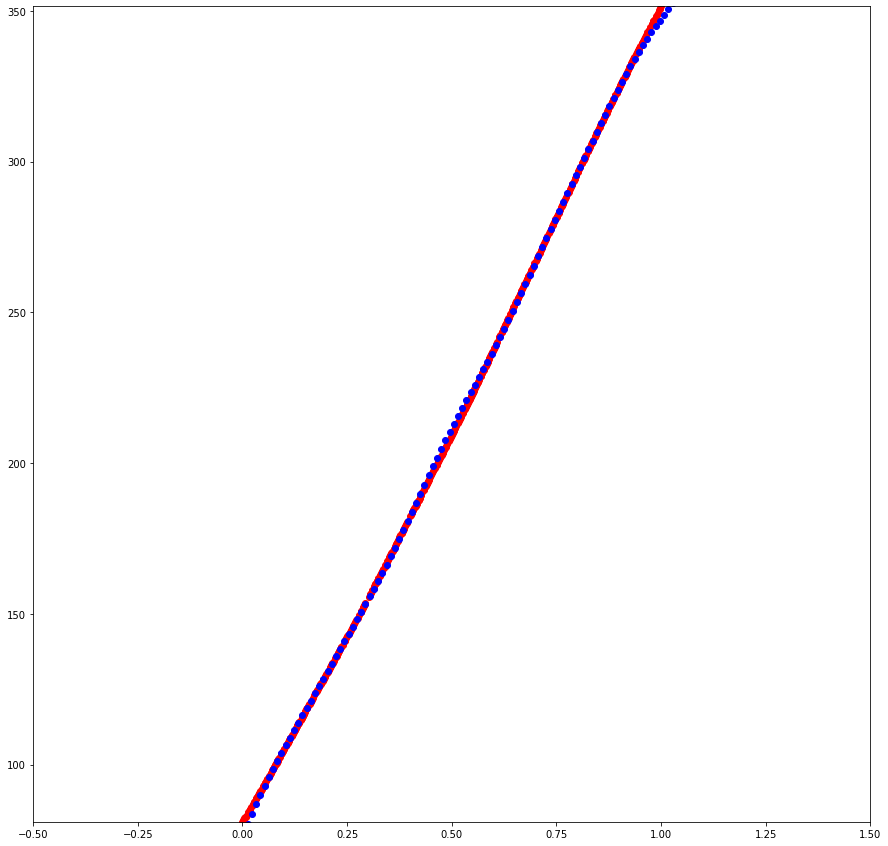

In [1454]:
kernel = ExpSineSquared(length_scale = 100, periodicity = 0.5, length_scale_bounds = (1E-3, 1E5),
                        periodicity_bounds = (1E-4, 1E3)) * DotProduct(sigma_0=1., sigma_0_bounds=(1e-05, 1e5))# \
#krreg = KernelRidge(alpha=0.00000001, kernel=kernel, gamma='linear', degree=5, coef0=1, kernel_params=None)

krreg = GaussianProcessRegressor(kernel=kernel, alpha=0.0000001)
0

X = dfdebreg.loc[norads[oi_num]].datetimes.apply(lambda x: x.timestamp()).values

#X = ppimport.normalize(X.reshape(-1, 1), norm='max', axis=0, copy=True, return_norm=False)

y = dfdebreg.loc[norads[oi_num]].m.values
#y = dfdebreg.loc[norads[oi_num]].argp.values

minmaxe = MinMaxScaler()
minmaxt = MinMaxScaler()
minmaxt.fit(X.reshape(-1, 1))
minmaxe.fit(np.array([0,1]).reshape(-1, 1))
y = minmaxe.transform(y.reshape(-1, 1))
X = minmaxt.transform(X.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), y,
                                                    test_size=0.33, random_state=42)
X_train = X
X_test = X
y_train = y
y_test = y
X_trainp = X_train
X_testp = X_test
X_testb = np.linspace(-0.5,1.5,200).reshape(-1,1)

#degree = 1
#poly_features = PolynomialFeatures(degree=degree)
#X_trainp = poly_features.fit_transform(X_train)
#X_testp = poly_features.fit_transform(X_test)
krreg.fit(X_trainp, y_train)

#y_pred = krreg.predict(X_testp)
y_pred = krreg.predict(X_testb)

#print(r2_score(y_test, y_pred))

ax = plt.figure(figsize = (15,15))
plt.xlim(-0.5,1.5)
plt.ylim(np.min(y_test),np.max(y_test))
plt.scatter(X_test, y_test, c = 'red')
plt.scatter(X_testb, y_pred, c = 'blue')
# better oscillatory interpolation